# Originally adapted from model_end_events_for_outages

In [1]:
%run ./model_end_events_for_outages_METHODS.ipynb

In [2]:
from importlib import reload
#reload(Utilities)
#reload(clm)
# NOTE: To reload a class imported as, e.g., 
# from module import class
# One must call:
#   1. import module
#   2. reload module
#   3. from module import class

import sys, os
import re
import string
from pathlib import Path
import json
import pickle
import joblib

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_datetime64_dtype, is_timedelta64_dtype
from scipy import stats
import datetime
import time
from natsort import natsorted, ns, natsort_keygen
from packaging import version
import copy
from functools import reduce

import itertools

import pyodbc
#---------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib import dates
import matplotlib.colors as mcolors
import matplotlib.cm as cm #e.g. for cmap=cm.jet
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#-----
import CommonLearningMethods as clm
#-----
from MeterPremise import MeterPremise
from EEMSP import EEMSP
#-----
from AMI_SQL import AMI_SQL
from AMINonVee_SQL import AMINonVee_SQL
from AMIEndEvents_SQL import AMIEndEvents_SQL
from AMIUsgInst_SQL import AMIUsgInst_SQL
from DOVSOutages_SQL import DOVSOutages_SQL
#-----
from GenAn import GenAn
from AMINonVee import AMINonVee
from AMIEndEvents import AMIEndEvents
from MECPODf import MECPODf
from MECPOAn import MECPOAn
from MECPOCollection import MECPOCollection
from AMIUsgInst import AMIUsgInst
from DOVSOutages import DOVSOutages
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_sql_aids_dir())
import Utilities_sql
import TableInfos
from TableInfos import TableInfo
from SQLElement import SQLElement
from SQLElementsCollection import SQLElementsCollection
from SQLSelect import SQLSelectElement, SQLSelect
from SQLFrom import SQLFrom
from SQLWhere import SQLWhereElement, SQLWhere
from SQLJoin import SQLJoin, SQLJoinCollection
from SQLGroupBy import SQLGroupByElement, SQLGroupBy
from SQLHaving import SQLHaving
from SQLOrderBy import SQLOrderByElement, SQLOrderBy
from SQLQuery import SQLQuery
from SQLQueryGeneric import SQLQueryGeneric
#---------------------------------------------------------------------
#sys.path.insert(0, os.path.join(os.path.realpath('..'), 'Utilities'))
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
from Utilities_df import DFConstructType
import Utilities_dt
import Plot_General
import Plot_Box_sns
import Plot_Hist
import Plot_Bar
import GrubbsTest
import DataFrameSubsetSlicer
from DataFrameSubsetSlicer import DataFrameSubsetSlicer as DFSlicer
from CustomJSON import CustomEncoder, CustomWriter

In [3]:
from sklearn.preprocessing import OrdinalEncoder

In [4]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras

import scipy

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# ---------------------------------------------------------------------------------------------------

In [5]:
fig_num=0

# save_dir_model_base = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230615\Models_00_05'
save_dir_model_base = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230615\Models'

In [6]:
save_results = False
# save_dir_model = None
save_dir_model = 'All_EEMSP_agg_Top10_v3'
if save_dir_model is None:
    save_dir_model = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
save_dir_model = os.path.join(save_dir_model_base, save_dir_model)
#-----
if not os.path.exists(save_dir_model) and save_results:
    os.makedirs(save_dir_model)

In [7]:
build_mecpo_colls = False

In [ ]:
if build_mecpo_colls:
    run_testing_data=False

    assert_all_cols_equal=True
    include_normalize_by_nSNs=True
    inclue_zero_counts=True
    return_multiindex_outg_reason=False
    return_normalized_separately=False

    if include_normalize_by_nSNs and not return_normalized_separately:
        normalize_by_nSNs_included=True
    else:
        normalize_by_nSNs_included=False

    xfmr_equip_typ_nms_of_interest = ['TRANSFORMER, OH', 'TRANSFORMER, UG']

    normalize_by_time_interval=True
    include_power_down_minus_up = False

In [ ]:
if build_mecpo_colls:
    # days_min_max_outg_td_windows=[
    #     [1,5], [6,10], [11,15], [16,20], [21,25], [26,30]
    # ]
    # old_to_new_keys_dict = {
    #     'outg_td_window_1_to_5_days'  :'01-05 Days',
    #     'outg_td_window_6_to_10_days' :'06-10 Days',
    #     'outg_td_window_11_to_15_days':'11-15 Days',
    #     'outg_td_window_16_to_20_days':'16-20 Days',
    #     'outg_td_window_21_to_25_days':'21-25 Days',
    #     'outg_td_window_26_to_30_days':'26-30 Days'
    # }


    # days_min_max_outg_td_windows=[
    #     [0,1], [1,2], [2,3], [3,4], [4,5]
    # ]
    # old_to_new_keys_dict = {
    #     'outg_td_window_0_to_1_days':'00-01 Days',
    #     'outg_td_window_1_to_2_days':'01-02 Days',
    #     'outg_td_window_2_to_3_days':'02-03 Days',
    #     'outg_td_window_3_to_4_days':'03-04 Days',
    #     'outg_td_window_4_to_5_days':'04-05 Days'
    # }

    days_min_max_outg_td_windows=[
        [1,6], [6,11], [11,16], [16,21], [21,26], [26,31]
    ]
    old_to_new_keys_dict = {
        'outg_td_window_1_to_6_days'  :'01-06 Days',
        'outg_td_window_6_to_11_days' :'06-11 Days',
        'outg_td_window_11_to_16_days':'11-16 Days',
        'outg_td_window_16_to_21_days':'16-21 Days',
        'outg_td_window_21_to_26_days':'21-26 Days',
        'outg_td_window_26_to_31_days':'26-31 Days'
    }

    #-------------------------
    assert(len(old_to_new_keys_dict)==len(days_min_max_outg_td_windows))

In [ ]:
if build_mecpo_colls:
    rcpo_dfs_name_outg          = 'rcpo_df_norm_by_xfmr_nSNs'
    rcpo_dfs_name_no_outg       = 'rcpo_df_norm_by_xfmr_nSNs'
    rcpo_dfs_name_no_outg_prstn = 'rcpo_df_norm_by_xfmr_nSNs'

    mecpo_idx_for_ordering = 0

    #-------------------------
    icpo_dfs_name_outg          = 'i'+rcpo_dfs_name_outg[1:]
    icpo_dfs_name_no_outg       = 'i'+rcpo_dfs_name_no_outg[1:]
    icpo_dfs_name_no_outg_prstn = 'i'+rcpo_dfs_name_no_outg_prstn[1:]

# Outages

In [ ]:
if build_mecpo_colls:
    run_date_outg = '20230615'
#     run_date_outg = '20231003'
    # event_date_ranges_outg = [
    #     ['2020-01-01', '2020-12-31'],
    #     ['2021-01-01', '2021-12-31'], 
    #     ['2022-01-01', '2022-09-30'], 
    # ]
    event_date_ranges_outg = [
        ['2022-01-01', '2022-12-31'], 
    ]
#     event_date_ranges_outg = [
#         ['2023-04-01', '2023-09-30'], 
#     ]
    grp_by_cols_outg = ['outg_rec_nb', 'trsf_pole_nb']

    mecpo_coll_full = build_and_combine_mecpo_colls_for_dates(
        dataset='outg_full', 
        acq_run_date=run_date_outg, 
        data_date_ranges=event_date_ranges_outg, 
        grp_by_cols=grp_by_cols_outg, 
        days_min_max_outg_td_windows=days_min_max_outg_td_windows, 
        old_to_new_keys_dict=old_to_new_keys_dict, 
        coll_label='Outages (All Xfmrs)', 
        barplot_kwargs_shared=dict(facecolor='red'), 
        normalize_by_time_interval=normalize_by_time_interval, 
        data_dir_base=r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data'
    )

# No outages

In [ ]:
if build_mecpo_colls:
    run_date_no_outg = '20230512'
    event_date_ranges_no_outg = [
        ['2022-01-01', '2022-12-31'], 
    ]
    grp_by_cols_no_outg = ['trsf_pole_nb', 'no_outg_rec_nb']

    mecpo_coll_no_outg = build_and_combine_mecpo_colls_for_dates(
        dataset='no_outg', 
        acq_run_date=run_date_no_outg, 
        data_date_ranges=event_date_ranges_no_outg, 
        grp_by_cols=grp_by_cols_no_outg, 
        days_min_max_outg_td_windows=days_min_max_outg_td_windows, 
        old_to_new_keys_dict=old_to_new_keys_dict, 
        coll_label='No Outages', 
        barplot_kwargs_shared=dict(facecolor='orange'), 
        normalize_by_time_interval=normalize_by_time_interval, 
        data_dir_base=r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data'
    )

# No outages pristine

In [ ]:
if build_mecpo_colls:
    run_date_no_outg_prstn = '20230301'
    event_date_ranges_prstn = [
        ['2022-01-01', '2022-12-31'], 
    ]
    grp_by_cols_no_outg_prstn = ['trsf_pole_nb', 'no_outg_rec_nb']

    mecpo_coll_no_outg_prstn = build_and_combine_mecpo_colls_for_dates(
        dataset='no_outg_prstn', 
        acq_run_date=run_date_no_outg_prstn, 
        data_date_ranges=event_date_ranges_prstn, 
        grp_by_cols=grp_by_cols_no_outg_prstn, 
        days_min_max_outg_td_windows=days_min_max_outg_td_windows, 
        old_to_new_keys_dict=old_to_new_keys_dict, 
        coll_label='No Outages', 
        barplot_kwargs_shared=dict(facecolor='orange'), 
        normalize_by_time_interval=normalize_by_time_interval, 
        data_dir_base=r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data'
    )

# Similarity operations

In [ ]:
if build_mecpo_colls:
    for an_key in mecpo_coll_full.mecpo_an_keys:
        print(f"{an_key}, 'rcpo_df_norm' shape: {mecpo_coll_full.get_cpo_df(an_key, 'rcpo_df_norm').shape}")

In [ ]:
if build_mecpo_colls:
    #-------------------------
    # First, make columns equal between MECPOAn objects within each MECPOCollection
    mecpo_coll_full.make_cpo_columns_equal(drop_empty_cpo_dfs=True)
    mecpo_coll_no_outg.make_cpo_columns_equal(drop_empty_cpo_dfs=True)
    mecpo_coll_no_outg_prstn.make_cpo_columns_equal(drop_empty_cpo_dfs=True)

    #-------------------------
    # Now, make columns equal between the MECPOCollections
    MECPOCollection.make_cpo_columns_equal_between_mecpo_colls(
        mecpo_colls = [
            mecpo_coll_full, 
            mecpo_coll_no_outg, 
            mecpo_coll_no_outg_prstn
        ], 
        drop_empty_cpo_dfs=True
    )

    #-------------------------
    # If not all same cpo_df names are used between collections, then one should call 
    #   MECPOCollection.make_mixed_cpo_columns_equal_between_mecpo_colls.
    if not(rcpo_dfs_name_outg==rcpo_dfs_name_no_outg==rcpo_dfs_name_no_outg_prstn):
        MECPOCollection.make_mixed_cpo_columns_equal_between_mecpo_colls(
            mecpo_colls_with_cpo_df_names = [
                [mecpo_coll_full, rcpo_dfs_name_outg], 
                [mecpo_coll_no_outg, rcpo_dfs_name_no_outg], 
                [mecpo_coll_no_outg_prstn, rcpo_dfs_name_no_outg_prstn]
            ], 
            segregate_by_mecpo_an_keys=False
        )
    #-------------------------
    if not(icpo_dfs_name_outg==icpo_dfs_name_no_outg==icpo_dfs_name_no_outg_prstn):
        MECPOCollection.make_mixed_cpo_columns_equal_between_mecpo_colls(
            mecpo_colls_with_cpo_df_names = [
                [mecpo_coll_full, icpo_dfs_name_outg], 
                [mecpo_coll_no_outg, icpo_dfs_name_no_outg], 
                [mecpo_coll_no_outg_prstn, icpo_dfs_name_no_outg_prstn]
            ], 
            segregate_by_mecpo_an_keys=False
        )

In [ ]:
if build_mecpo_colls:
    for an_key in mecpo_coll_full.mecpo_an_keys:
        print(f"{an_key}, 'rcpo_df_norm' shape: {mecpo_coll_full.get_cpo_df(an_key, 'rcpo_df_norm').shape}")

In [ ]:
if build_mecpo_colls:
    mecpo_coll_full.get_cpo_df(mecpo_coll_full.mecpo_an_keys[0], 'rcpo_df_norm').columns

In [ ]:
if build_mecpo_colls:
    start=time.time()
    #-------------------------
    # Remove all reasons containing 'cleared'
    mecpo_coll_full.remove_reasons_from_all_rcpo_dfs(['.*cleared.*', '.*Test Mode.*'])
    mecpo_coll_no_outg.remove_reasons_from_all_rcpo_dfs(['.*cleared.*', '.*Test Mode.*'])
    mecpo_coll_no_outg_prstn.remove_reasons_from_all_rcpo_dfs(['.*cleared.*', '.*Test Mode.*'])

    #-------------------------
    # Combine reasons using the standard combine (see dflt_patterns_and_replace in MECPODf.combine_cpo_df_reasons
    #   for the list of default patterns_and_replace)
    red_to_org_cols_dicts_full    = mecpo_coll_full.combine_reasons_in_all_rcpo_dfs(
        initial_strip=True, initial_punctuation_removal=True, return_red_to_org_cols_dict=True
    )
    red_to_org_cols_dicts_no_outg = mecpo_coll_no_outg.combine_reasons_in_all_rcpo_dfs(
        initial_strip=True, initial_punctuation_removal=True, return_red_to_org_cols_dict=True
    ) 
    red_to_org_cols_dicts_no_outg_prstn = mecpo_coll_no_outg_prstn.combine_reasons_in_all_rcpo_dfs(
        initial_strip=True, initial_punctuation_removal=True, return_red_to_org_cols_dict=True
    ) 
    print(time.time()-start)
    #-------------------------
    # Build power down minus power up counts
    if include_power_down_minus_up:
        mecpo_coll_full.delta_cpo_df_reasons_in_all_rcpo_dfs(
            reasons_1='Primary Power Down',
            reasons_2='Primary Power Up',
            delta_reason_name='Power Down Minus Up'
        )
        mecpo_coll_no_outg.delta_cpo_df_reasons_in_all_rcpo_dfs(
            reasons_1='Primary Power Down',
            reasons_2='Primary Power Up',
            delta_reason_name='Power Down Minus Up'
        )
        mecpo_coll_no_outg_prstn.delta_cpo_df_reasons_in_all_rcpo_dfs(
            reasons_1='Primary Power Down',
            reasons_2='Primary Power Up',
            delta_reason_name='Power Down Minus Up'
        )

In [ ]:
if build_mecpo_colls:
    #-------------------------
    # Don't want to include SNs or nSNs cols (and similar) in plotting, so remove
    mecpo_coll_full.remove_SNs_cols_from_all_cpo_dfs()
    mecpo_coll_no_outg.remove_SNs_cols_from_all_cpo_dfs()
    mecpo_coll_no_outg_prstn.remove_SNs_cols_from_all_cpo_dfs()

In [ ]:
if build_mecpo_colls:
    for an_key in mecpo_coll_full.mecpo_an_keys:
        print(f"{an_key}, 'rcpo_df_norm' shape: {mecpo_coll_full.get_cpo_df(an_key, 'rcpo_df_norm').shape}")

# =================================================

# Get merged DFs from collections

In [ ]:
if build_mecpo_colls:
    # cpo_df_subset_by_mjr_mnr_cause_args=dict(
    #     mjr_cause='DL',
    #     mnr_cause='OL', 
    #     addtnl_slicers=None, 
    # )
    # cpo_df_subset_by_mjr_mnr_cause_args=dict(
    #     mjr_cause='DL',
    #     mnr_cause='EQF', 
    #     addtnl_slicers=None, 
    # )
    cpo_df_subset_by_mjr_mnr_cause_args=None


    max_total_counts=None
    # max_total_counts=150
    # max_total_counts=100
    # max_total_counts={
    #     '01-05 Days':150, 
    #     '06-10 Days':150, 
    #     '11-15 Days':150, 
    #     '16-20 Days':150,
    #     '21-25 Days':150, 
    #     '26-30 Days':150
    # }

    merged_df_full = mecpo_coll_full.get_merged_cpo_dfs(
    #     'rcpo_df_norm_by_outg_nSNs', 
        'rcpo_df_norm_by_xfmr_nSNs', 
    #     'rcpo_df_raw', 
        cpo_df_subset_by_mjr_mnr_cause_args=cpo_df_subset_by_mjr_mnr_cause_args, 
        max_total_counts=max_total_counts
    )
    merged_df_no_outg = mecpo_coll_no_outg.get_merged_cpo_dfs(
        'rcpo_df_norm_by_xfmr_nSNs', 
    #     'rcpo_df_raw', 
        cpo_df_subset_by_mjr_mnr_cause_args=None, 
        max_total_counts=max_total_counts
    )
    merged_df_no_outg_prstn = mecpo_coll_no_outg_prstn.get_merged_cpo_dfs(
        'rcpo_df_norm_by_xfmr_nSNs', 
    #     'rcpo_df_raw', 
        cpo_df_subset_by_mjr_mnr_cause_args=None, 
        max_total_counts=max_total_counts
    )


    # Make sure all SNs columns are removed
    merged_df_full          = MECPODf.remove_SNs_cols_from_rcpo_df(merged_df_full)
    merged_df_no_outg       = MECPODf.remove_SNs_cols_from_rcpo_df(merged_df_no_outg)
    merged_df_no_outg_prstn = MECPODf.remove_SNs_cols_from_rcpo_df(merged_df_no_outg_prstn)

In [ ]:
if build_mecpo_colls:
    merged_df_full          = merged_df_full[merged_df_full.columns.sort_values()]
    merged_df_no_outg       = merged_df_no_outg[merged_df_no_outg.columns.sort_values()]
    merged_df_no_outg_prstn = merged_df_no_outg_prstn[merged_df_no_outg_prstn.columns.sort_values()]

In [ ]:
if build_mecpo_colls:
    print(all(merged_df_no_outg.columns==merged_df_full.columns))
    print(all(merged_df_no_outg.columns==merged_df_no_outg_prstn.columns))

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
# NOTE: Cannot do get_top_reasons_subset_from_merged_cpo_df for each, as they will then in general have unequal columns!

In [ ]:
if build_mecpo_colls:
    # counts_series_full          = mecpo_coll_full.get_counts_series('rcpo_df_norm_by_outg_nSNs', False)
    counts_series_full          = mecpo_coll_full.get_counts_series('rcpo_df_norm_by_xfmr_nSNs', False)

    counts_series_no_outg       = mecpo_coll_no_outg.get_counts_series('rcpo_df_norm_by_xfmr_nSNs', False)

    counts_series_no_outg_prstn = mecpo_coll_no_outg_prstn.get_counts_series('rcpo_df_norm_by_xfmr_nSNs', False)

# SAVE OR LOAD

In [ ]:
if build_mecpo_colls:
    merged_df_full.to_pickle(os.path.join(save_dir_model_base, 'merged_df_full.pkl'))
    merged_df_no_outg.to_pickle(os.path.join(save_dir_model_base, 'merged_df_no_outg.pkl'))
    merged_df_no_outg_prstn.to_pickle(os.path.join(save_dir_model_base, 'merged_df_no_outg_prstn.pkl'))
    #-------------------------
    with open(os.path.join(save_dir_model_base, 'mecpo_coll_full.pkl'), 'wb') as handle:
        pickle.dump(mecpo_coll_full, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(save_dir_model_base, 'mecpo_coll_no_outg.pkl'), 'wb') as handle:
        pickle.dump(mecpo_coll_no_outg, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(save_dir_model_base, 'mecpo_coll_no_outg_prstn.pkl'), 'wb') as handle:
        pickle.dump(mecpo_coll_no_outg_prstn, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #-------------------------
    with open(os.path.join(save_dir_model_base, 'counts_series_full.pkl'), 'wb') as handle:
        pickle.dump(counts_series_full, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(save_dir_model_base, 'counts_series_no_outg.pkl'), 'wb') as handle:
        pickle.dump(counts_series_no_outg, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(save_dir_model_base, 'counts_series_no_outg_prstn.pkl'), 'wb') as handle:
        pickle.dump(counts_series_no_outg_prstn, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
if not build_mecpo_colls:
    combine_others=True

    merged_df_full=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_full.pkl'))
    merged_df_no_outg=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_no_outg.pkl'))
    merged_df_no_outg_prstn=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_no_outg_prstn.pkl'))
    #-------------------------
    # with open(os.path.join(save_dir_model_base, 'mecpo_coll_full.pkl'), 'rb') as handle:
    #     mecpo_coll_full = pickle.load(handle)
    # with open(os.path.join(save_dir_model_base, 'mecpo_coll_no_outg.pkl'), 'rb') as handle:
    #     mecpo_coll_no_outg = pickle.load(handle)
    # with open(os.path.join(save_dir_model_base, 'mecpo_coll_no_outg_prstn.pkl'), 'rb') as handle:
    #     mecpo_coll_no_outg_prstn = pickle.load(handle)
    #-------------------------
    with open(os.path.join(save_dir_model_base, 'counts_series_full.pkl'), 'rb') as handle:
        counts_series_full = pickle.load(handle)
    with open(os.path.join(save_dir_model_base, 'counts_series_no_outg.pkl'), 'rb') as handle:
        counts_series_no_outg = pickle.load(handle)
    with open(os.path.join(save_dir_model_base, 'counts_series_no_outg_prstn.pkl'), 'rb') as handle:
        counts_series_no_outg_prstn = pickle.load(handle)

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    merged_df_no_outg_prstn.index.names     = ['trsf_pole_nb', 'no_outg_rec_nb']
    counts_series_no_outg_prstn.index.names = ['trsf_pole_nb', 'no_outg_rec_nb']

In [9]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(123234, 186)
(599500, 186)
(178946, 186)


In [10]:
natsorted(merged_df_full.columns.get_level_values(1).unique().tolist())

['Access Point has lost connectivity with FHSS 900 MHz band',
 'Demand Reset',
 'Detected end of voltage sag',
 'Detected end of voltage swell',
 'Device Failed',
 'Device exceeded the max allowable trap threshold',
 'Diag1: Polarity, Cross Phase, Reverse Energy Flow: Angle out of tolerance',
 'Error occurred when attempting to synch meter time with NIC time for device',
 'Ignoring Read: time in the future',
 'Last Gasp',
 'Low Battery',
 'Measurement Error (C1219 Table 3)',
 'Meter Program Seal mismatch for Device',
 'Meter detected a high temperature condition (C1219 Table 3)',
 'Meter detected loss of time (C1219 Table 3)',
 'Meter needs explicit time sync',
 'N/A failed consecutively for 1 or more times',
 'NET_MGMT command failed consecutively',
 'NET_MGMT command has insufficient privileges',
 'NIC Link Layer Handshake Failed',
 'NIC Power Restore Trap Received from device',
 'NVRAM Error',
 'Over Voltage',
 'Primary Power Down',
 'Primary Power Up',
 'ROM Error (C1219 Table 3)',

### Initiate summary_dict

In [12]:
summary_dict = dict()
#-------------------------
an_keys = natsorted(merged_df_full.columns.get_level_values(0).unique().tolist())
assert(an_keys==natsorted(merged_df_no_outg.columns.get_level_values(0).unique().tolist()))
assert(an_keys==natsorted(merged_df_no_outg_prstn.columns.get_level_values(0).unique().tolist()))
#-----
summary_dict['an_keys'] = an_keys
#-------------------------
n_top_reasons_to_inclue = 10
# n_top_reasons_to_inclue = None
#-----
summary_dict['n_top_reasons_to_inclue'] = n_top_reasons_to_inclue

### !!!!!!! No outage data have indices backwards from outages!!!!!

In [13]:
merged_df_no_outg = merged_df_no_outg.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
counts_series_no_outg = counts_series_no_outg.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb']).squeeze()
#-----
merged_df_no_outg_prstn = merged_df_no_outg_prstn.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
counts_series_no_outg_prstn = counts_series_no_outg_prstn.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb']).squeeze()

In [14]:
merged_df_full.columns.get_level_values(1).unique().tolist()

['Access Point has lost connectivity with FHSS 900 MHz band',
 'Demand Reset',
 'Detected end of voltage sag',
 'Detected end of voltage swell',
 'Device Failed',
 'Device exceeded the max allowable trap threshold',
 'Diag1: Polarity, Cross Phase, Reverse Energy Flow: Angle out of tolerance',
 'Error occurred when attempting to synch meter time with NIC time for device',
 'Ignoring Read: time in the future',
 'Last Gasp',
 'Low Battery',
 'Measurement Error (C1219 Table 3)',
 'Meter Program Seal mismatch for Device',
 'Meter detected a high temperature condition (C1219 Table 3)',
 'Meter detected loss of time (C1219 Table 3)',
 'Meter needs explicit time sync',
 'N/A failed consecutively for 1 or more times',
 'NET_MGMT command failed consecutively',
 'NET_MGMT command has insufficient privileges',
 'NIC Link Layer Handshake Failed',
 'NIC Power Restore Trap Received from device',
 'NVRAM Error',
 'Over Voltage',
 'Primary Power Down',
 'Primary Power Up',
 'ROM Error (C1219 Table 3)',

In [15]:
if Path(save_dir_model_base).name=='Models' or Path(save_dir_model_base).name=='Models_00_05':
    is_norm=True
elif Path(save_dir_model_base).name=='Models_raw' or Path(save_dir_model_base).name=='Models_00_05_raw':
    is_norm=False
else:
    assert(0)

if n_top_reasons_to_inclue is not None:
    merged_df_full, [merged_df_no_outg, merged_df_no_outg_prstn] = MECPOCollection.get_top_reasons_subset_from_merged_cpo_df_and_project_from_others(
        merged_cpo_df=merged_df_full,
        other_dfs_w_counts_series=[ 
            [merged_df_no_outg, counts_series_no_outg], 
            [merged_df_no_outg_prstn, counts_series_no_outg_prstn]
        ], 
        how='per_mecpo_an', 
        n_reasons_to_include=n_top_reasons_to_inclue,
        combine_others=combine_others,
        output_combine_others_col='Other Reasons',
        SNs_tags=None, 
        is_norm=is_norm, 
        counts_series=counts_series_full
    )

In [16]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(123234, 66)
(599500, 66)
(178946, 66)


In [17]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(123234, 66)
(599500, 66)
(178946, 66)


In [18]:
merged_df_full=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_full)
merged_df_no_outg=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_no_outg)
merged_df_no_outg_prstn=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_no_outg_prstn)

In [19]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(123234, 72)
(599500, 72)
(178946, 72)


In [20]:
assert(len(set(merged_df_full.index).difference(set(counts_series_full.index)))==0)
assert(len(set(merged_df_no_outg.index).difference(set(counts_series_no_outg.index)))==0)
assert(len(set(merged_df_no_outg_prstn.index).difference(set(counts_series_no_outg_prstn.index)))==0)

merged_df_full = pd.merge(
    merged_df_full, 
    counts_series_full.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

merged_df_no_outg = pd.merge(
    merged_df_no_outg, 
    counts_series_no_outg.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

merged_df_no_outg_prstn = pd.merge(
    merged_df_no_outg_prstn, 
    counts_series_no_outg_prstn.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

In [21]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(123234, 73)
(599500, 73)
(178946, 73)


In [22]:
merged_df_full

01-06 Days                   \
                           Detected end of voltage sag Primary Power Up   
outg_rec_nb trsf_pole_nb                                                  
13273510    1831084763656                          0.0              0.0   
            1831245763849                          0.0              0.0   
            1831411763624                          0.0              0.0   
            1831518763833                          0.0              0.0   
            1831636763610                          0.0              0.0   
...                                                ...              ...   
13610644    2117114486313                          0.0              0.0   
13610648    1864592762329                          0.0              0.0   
13610670    1838722795015                          0.0              0.0   
13610714    41810727000443                         0.0              0.0   
13610730    1830661773791                          0.0              0.0   

                                               \
                           Primary Power Down   
outg_rec_nb trsf_pole_nb                        
13273510    1831084763656                 0.0   
            1831245763849                 0.0   
            1831411763624                 0.0   
            1831518763833                 0.0   
            1831636763610                 0.0   
...                                       ...   
13610644    2117114486313                 0.0   
13610648    1864592762329                 0.0   
13610670    1838722795015                 0.0   
13610714    41810727000443                0.0   
13610730    1830661773791                 0.0   

                                                                  \
                           NET_MGMT command failed consecutively   
outg_rec_nb trsf_pole_nb                                           
13273510    1831084763656                               0.000000   
            1831245763849                               0.083333   
            1831411763624                               0.000000   
            1831518763833                               0.000000   
            1831636763610                               0.000000   
...                                                          ...   
13610644    2117114486313                               0.000000   
13610648    1864592762329                               0.116667   
13610670    1838722795015                               0.000000   
13610714    41810727000443                              0.000000   
13610730    1830661773791                               0.000000   

                                                                                                        \
                           Error occurred when attempting to synch meter time with NIC time for device   
outg_rec_nb trsf_pole_nb                                                                                 
13273510    1831084763656                                            0.000000                            
            1831245763849                                            0.000000                            
            1831411763624                                            0.000000                            
            1831518763833                                            0.000000                            
            1831636763610                                            0.000000                            
...                                                                       ...                            
13610644    2117114486313                                            0.000000                            
13610648    1864592762329                                            0.033333                            
13610670    1838722795015                                            0.000000                            
13610714    41810727000443                                           0.000000    

In [23]:
print(merged_df_full.shape)
print(merged_df_full.index.get_level_values(0).nunique())
print(merged_df_full.index.get_level_values(1).nunique())

(123234, 73)
11289
81688


In [24]:
merged_df_full.index.get_level_values(1).value_counts()

trsf_pole_nb
PRIMARY           294
1880927725719      10
1917344719408      10
1916774719511      10
1911533717166       9
                 ... 
40820506C20076      1
40820506C20078      1
40820506C20081      1
40820506D10122      1
1830661773791       1
Name: count, Length: 81688, dtype: int64

In [25]:
# merged_df_full['01-05 Days']
# merged_df_full['00-01 Days']

In [26]:
merged_df_full

01-06 Days                   \
                           Detected end of voltage sag Primary Power Up   
outg_rec_nb trsf_pole_nb                                                  
13273510    1831084763656                          0.0              0.0   
            1831245763849                          0.0              0.0   
            1831411763624                          0.0              0.0   
            1831518763833                          0.0              0.0   
            1831636763610                          0.0              0.0   
...                                                ...              ...   
13610644    2117114486313                          0.0              0.0   
13610648    1864592762329                          0.0              0.0   
13610670    1838722795015                          0.0              0.0   
13610714    41810727000443                         0.0              0.0   
13610730    1830661773791                          0.0              0.0   

                                               \
                           Primary Power Down   
outg_rec_nb trsf_pole_nb                        
13273510    1831084763656                 0.0   
            1831245763849                 0.0   
            1831411763624                 0.0   
            1831518763833                 0.0   
            1831636763610                 0.0   
...                                       ...   
13610644    2117114486313                 0.0   
13610648    1864592762329                 0.0   
13610670    1838722795015                 0.0   
13610714    41810727000443                0.0   
13610730    1830661773791                 0.0   

                                                                  \
                           NET_MGMT command failed consecutively   
outg_rec_nb trsf_pole_nb                                           
13273510    1831084763656                               0.000000   
            1831245763849                               0.083333   
            1831411763624                               0.000000   
            1831518763833                               0.000000   
            1831636763610                               0.000000   
...                                                          ...   
13610644    2117114486313                               0.000000   
13610648    1864592762329                               0.116667   
13610670    1838722795015                               0.000000   
13610714    41810727000443                              0.000000   
13610730    1830661773791                               0.000000   

                                                                                                        \
                           Error occurred when attempting to synch meter time with NIC time for device   
outg_rec_nb trsf_pole_nb                                                                                 
13273510    1831084763656                                            0.000000                            
            1831245763849                                            0.000000                            
            1831411763624                                            0.000000                            
            1831518763833                                            0.000000                            
            1831636763610                                            0.000000                            
...                                                                       ...                            
13610644    2117114486313                                            0.000000                            
13610648    1864592762329                                            0.033333                            
13610670    1838722795015                                            0.000000                            
13610714    41810727000443                                           0.000000    

# =========================================================
# =========================================================

# Build/grab time_info DFs

In [27]:
build_time_infos_dfs=False

In [28]:
ede_data_dirs_no_outg = [
#     r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\20200101_20201231\EndEvents_NoOutg', 
#     r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\20210101_20211231\EndEvents_NoOutg', 
    r'U:\CloudData\dovs_and_end_events_data\20230512\20220101_20221231\NoOutgs\EndEvents'
]
#-----
ede_data_dirs_no_outg_prstn = [
#     r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230301\20200101_20201231\NoOutgs_Pristine\EndEvents', 
#     r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230301\20210101_20211231\NoOutgs_Pristine\EndEvents', 
    r'U:\CloudData\dovs_and_end_events_data\20230301\20220101_20221231\NoOutgs_Pristine\EndEvents'    
]

In [31]:
if build_time_infos_dfs:
    time_infos_df_outg = build_outg_time_infos_df(
        rcpx_df=merged_df_full.copy(), 
        outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
        dummy_col_levels_prefix='dummy_lvl_',     
    )
    time_infos_df_outg.to_pickle(os.path.join(save_dir_model_base, 'time_infos_df_outg.pkl'))    
    #-----
    no_outg_time_infos_df = build_no_outg_time_infos_df(
        ede_data_dirs_no_outg=ede_data_dirs_no_outg,
        save_path=os.path.join(save_dir_model_base, 'no_outg_time_infos_df.pkl')
    )
    #-----
    no_outg_time_infos_prstn_df = build_no_outg_time_infos_df(
        ede_data_dirs_no_outg=ede_data_dirs_no_outg_prstn,
        save_path=os.path.join(save_dir_model_base, 'no_outg_time_infos_prstn_df.pkl')
    )
else:
    time_infos_df_outg          = pd.read_pickle(os.path.join(save_dir_model_base, 'time_infos_df_outg.pkl'))
    no_outg_time_infos_df       = pd.read_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_df.pkl'))
    no_outg_time_infos_prstn_df = pd.read_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_prstn_df.pkl'))
#-------------------------
if 'is_first_after_outg' in no_outg_time_infos_df.index.names:
    no_outg_time_infos_df = no_outg_time_infos_df.droplevel(level='is_first_after_outg', axis=0)
#-----
if 'is_first_after_outg' in no_outg_time_infos_prstn_df.index.names:
    no_outg_time_infos_prstn_df = no_outg_time_infos_prstn_df.droplevel(level='is_first_after_outg', axis=0)
    
#-------------------------
# NOTE: After new DFs are built and saved (using build_no_outg_time_infos_df), the if statements
#         below will no longer be necessary
# Typically, want index as ['no_outg_rec_nb', 'trsf_pole_nb']
if no_outg_time_infos_df.index.names!=['no_outg_rec_nb', 'trsf_pole_nb']:
    no_outg_time_infos_df = no_outg_time_infos_df.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
#-----
if no_outg_time_infos_prstn_df.index.names!=['no_outg_rec_nb', 'trsf_pole_nb']:
    no_outg_time_infos_prstn_df = no_outg_time_infos_prstn_df.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
    
#-------------------------
# Make sure time info found for all
# For the baseline data, typically the time dfs will have more entries than the data
#   This can result from, e.g., transformers not registering any events, in which case
#     they obviously will not be found in the data, but will be found in the time dfs because
#     those are built through the collection of run SQL queries
assert(len(set(merged_df_full.index).difference(set(time_infos_df_outg.index)))==0)
assert(len(set(merged_df_no_outg.index).difference(set(no_outg_time_infos_df.index)))==0)
assert(len(set(merged_df_no_outg_prstn.index).difference(set(no_outg_time_infos_prstn_df.index)))==0)

# =========================================================
# =========================================================

# EEMSP

In [33]:
merge_eemsp = True
build_eemsp = False
mult_strategy='agg'
#-----
cols_of_interest_eemsp = [
    'LOCATION_NB', 
    'MFGR_NM', 
    'INSTALL_DT', 
    'LAST_TRANS_DESC', 
    'EQTYPE_ID', 
    'COOLANT', 
    'INFO', 
    'KVA_SIZE',
    'PHASE_CNT', 
    'PRIM_VOLTAGE', 
    'PROTECTION', 
    'PRU_NUMBER', 
    'SEC_VOLTAGE', 
    'SPECIAL_CHAR', 
    'TAPS', 
    'XFTYPE'
]
cols_of_interest_eemsp_full = cols_of_interest_eemsp + ['LATEST_STATUS', 'REMOVAL_DT', 'SERIAL_NB']
#-------------------------
summary_dict['merge_eemsp']         = merge_eemsp
summary_dict['eemsp_mult_strategy'] = mult_strategy

In [34]:
if merge_eemsp:
    #----------------------------------------------------------------------------------------------------
    # Grab or build df_eemsp_full
    #--------------------------------------------------
    trsf_pole_nbs = list(set(
        merged_df_full.index.get_level_values(1).unique().tolist()+
        merged_df_no_outg.index.get_level_values(1).unique().tolist()+
        merged_df_no_outg_prstn.index.get_level_values(1).unique().tolist()
    ))
    #-------------------------
    if build_eemsp:
        conn_eemsp = Utilities.get_eemsp_oracle_connection()
        df_eemsp_OG = build_df_eemsp(conn_eemsp, trsf_pole_nbs, batch_size=1000, verbose=True, n_update=10)
        df_eemsp_OG.to_pickle(os.path.join(save_dir_model_base, 'df_eemsp_OG.pkl'))
    else:
        df_eemsp_OG = pd.read_pickle(os.path.join(save_dir_model_base, 'df_eemsp_OG.pkl'))
    #-------------------------
    df_eemsp_full = df_eemsp_OG.copy()
    
    #----------------------------------------------------------------------------------------------------
    # Build time_infos_df
    #--------------------------------------------------
    time_infos_df_no_outg = build_no_outg_time_infos_df_for_eemsp(
        no_outg_time_infos_df=no_outg_time_infos_df
    )
    #-----
    time_infos_df_no_outg_prstn = build_no_outg_time_infos_df_for_eemsp(
        no_outg_time_infos_df=no_outg_time_infos_prstn_df
    )
    #-------------------------
    time_infos_df = build_time_infos_df_for_eemsp(
        time_infos_df_outg=time_infos_df_outg, 
        time_infos_df_no_outg=time_infos_df_no_outg, 
        time_infos_df_no_outg_prstn=time_infos_df_no_outg_prstn
    )
    #-------------------------
    assert(time_infos_df.shape[0]==time_infos_df.reset_index().drop_duplicates().shape[0])
    #-----
    del time_infos_df_outg
    del time_infos_df_no_outg
    del time_infos_df_no_outg_prstn
    
    #----------------------------------------------------------------------------------------------------
    # Run reduce1 (or grab reduced df, depending on build_eemsp), keeping only entries from df_eemsp_full 
    #   active at the correct time periods
    #--------------------------------------------------
    if build_eemsp:
        df_eemsp_full = df_eemsp_full[cols_of_interest_eemsp_full].copy()
        #-----
        df_eemsp_reduce1 = reduce1_eemsp_for_outg_trsf(
            time_infos_df=time_infos_df, 
            df_eemsp=df_eemsp_full, 
            outg_rec_nb_idfr  = 'index_0', 
            trsf_pole_nb_idfr = 'index_1', 
            dt_min_col = 't_min', 
            dt_max_col = 't_max', 

            eemsp_location_nb_col = 'LOCATION_NB', 
            eemsp_install_dt_col  = 'INSTALL_DT', 
            eemsp_removal_dt_col  = 'REMOVAL_DT', 
            return_eemsp_outg_rec_nb_col = 'OUTG_REC_NB_TO_MERGE'
        )
        df_eemsp_reduce1.to_pickle(os.path.join(save_dir_model_base, 'df_eemsp_reduce1.pkl'))
    else:
        df_eemsp_reduce1 = pd.read_pickle(os.path.join(save_dir_model_base, 'df_eemsp_reduce1.pkl'))
        
    #----------------------------------------------------------------------------------------------------
    # Run reduce2 (or grab reduced df, depending on build_eemsp and whether or not reduced2 df exists), 
    #   keeping only one entry per outg_rec_nb, location_nb (trsf_pole_nb) group
    #--------------------------------------------------
    if(
        not build_eemsp and 
        os.path.exists(os.path.join(save_dir_model_base, f'df_eemsp_reduce2_{mult_strategy}.pkl'))
    ):
        df_eemsp_reduce2 = pd.read_pickle(os.path.join(save_dir_model_base, f'df_eemsp_reduce2_{mult_strategy}.pkl'))
    else:
        df_eemsp_reduce2 = reduce2_eemsp_for_outg_trsf(
            df_eemsp=df_eemsp_reduce1.copy(), 
            mult_strategy=mult_strategy, 
            outg_rec_nb_col='OUTG_REC_NB_TO_MERGE', 
            location_nb_col='LOCATION_NB', 
            numeric_cols = ['KVA_SIZE'], 
            dt_cols = ['INSTALL_DT', 'REMOVAL_DT'], 
            ignore_cols = ['SERIAL_NB'], 
        )
        df_eemsp_reduce2.to_pickle(os.path.join(save_dir_model_base, f'df_eemsp_reduce2_{mult_strategy}.pkl'))  
    #-------------------------
    # No matter of the mult_strategy used, at this point df_eemsp_reduce2 should only have a single
    #   entry for each outg_rec_nb, location_nb pair
    assert(all(df_eemsp_reduce2[['OUTG_REC_NB_TO_MERGE', 'LOCATION_NB']].value_counts()==1))
    
    #----------------------------------------------------------------------------------------------------
    # Clean up df_eemsp_reduce2 and merge with merged_df_full, merged_df_no_outg, and merged_df_no_outg_prstn
    #--------------------------------------------------
    # Can't simply take df_eemsp_reduce2[cols_of_interest_eemsp] because we need also the new column
    #   OUTG_REC_NB_TO_MERGE (and ant others which may be added in the future)
    cols_to_drop = list(set(cols_of_interest_eemsp_full).difference(set(cols_of_interest_eemsp)))
    cols_to_drop = [x for x in cols_to_drop if x in df_eemsp_reduce2.columns]
    if len(cols_to_drop)>0:
        df_eemsp_reduce2 = df_eemsp_reduce2.drop(columns=cols_to_drop)
    #-------------------------
    assert(df_eemsp_reduce2.shape[0]==df_eemsp_reduce2.groupby(['OUTG_REC_NB_TO_MERGE', 'LOCATION_NB']).ngroups)
    print(f"df_eemsp_reduce2['LOCATION_NB'].nunique() = {df_eemsp_reduce2['LOCATION_NB'].nunique()}")
    print(f"len(trsf_pole_nbs)                        = {len(trsf_pole_nbs)}")
    print(f"Diff                                      = {len(trsf_pole_nbs)-df_eemsp_reduce2['LOCATION_NB'].nunique()}")
    print()
    #-------------------------
    print("\nShapes BEFORE merging")
    print(f"merged_df_full.shape          = {merged_df_full.shape}")
    print(f"merged_df_no_outg.shape       = {merged_df_no_outg.shape}")
    print(f"merged_df_no_outg_prstn.shape = {merged_df_no_outg_prstn.shape}")
    #-------------------------
    merged_df_full = merge_rcpx_with_eemsp(
        df_rcpx=merged_df_full, 
        df_eemsp=df_eemsp_reduce2, 
        outg_rec_nb_idfr_rcpx ='index_0', 
        trsf_pole_nb_idfr_rcpx='index_1', 
        outg_rec_nb_idfr_eemsp='OUTG_REC_NB_TO_MERGE', 
        location_nb_idfr_eemsp='LOCATION_NB', 
        set_index=True
    )
    #-------------------------
    merged_df_no_outg = merge_rcpx_with_eemsp(
        df_rcpx=merged_df_no_outg, 
        df_eemsp=df_eemsp_reduce2, 
        outg_rec_nb_idfr_rcpx ='index_0', 
        trsf_pole_nb_idfr_rcpx='index_1', 
        outg_rec_nb_idfr_eemsp='OUTG_REC_NB_TO_MERGE', 
        location_nb_idfr_eemsp='LOCATION_NB', 
        set_index=True
    )
    #-------------------------
    merged_df_no_outg_prstn = merge_rcpx_with_eemsp(
        df_rcpx=merged_df_no_outg_prstn, 
        df_eemsp=df_eemsp_reduce2, 
        outg_rec_nb_idfr_rcpx ='index_0', 
        trsf_pole_nb_idfr_rcpx='index_1', 
        outg_rec_nb_idfr_eemsp='OUTG_REC_NB_TO_MERGE', 
        location_nb_idfr_eemsp='LOCATION_NB', 
        set_index=True
    )
    #-------------------------
    print("\nShapes AFTER merging")
    print(f"merged_df_full.shape          = {merged_df_full.shape}")
    print(f"merged_df_no_outg.shape       = {merged_df_no_outg.shape}")
    print(f"merged_df_no_outg_prstn.shape = {merged_df_no_outg_prstn.shape}")

n_trsf_pole_nbs = 195520
batch_size = 1000
n_batches = 196


C:\Temp/ipykernel_30336/3103456106.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_eemsp_i = pd.read_sql_query(sql_eemsp_i, conn_eemsp)


10/196
20/196
30/196
40/196
50/196
60/196
70/196
80/196
90/196
100/196
110/196
120/196
130/196
140/196
150/196
160/196
170/196
180/196
190/196
0 of 1844671
1000 of 1844671
2000 of 1844671
3000 of 1844671
4000 of 1844671
5000 of 1844671
6000 of 1844671
7000 of 1844671
8000 of 1844671
9000 of 1844671
10000 of 1844671
11000 of 1844671
12000 of 1844671
13000 of 1844671
14000 of 1844671
15000 of 1844671
16000 of 1844671
17000 of 1844671
18000 of 1844671
19000 of 1844671
20000 of 1844671
21000 of 1844671
22000 of 1844671
23000 of 1844671
24000 of 1844671
25000 of 1844671
26000 of 1844671
27000 of 1844671
28000 of 1844671
29000 of 1844671
30000 of 1844671
31000 of 1844671
32000 of 1844671
33000 of 1844671
34000 of 1844671
35000 of 1844671
36000 of 1844671
37000 of 1844671
38000 of 1844671
39000 of 1844671
40000 of 1844671
41000 of 1844671
42000 of 1844671
43000 of 1844671
44000 of 1844671
45000 of 1844671
46000 of 1844671
47000 of 1844671
48000 of 1844671
49000 of 1844671
50000 of 1844671
510

454000 of 1844671
455000 of 1844671
456000 of 1844671
457000 of 1844671
458000 of 1844671
459000 of 1844671
460000 of 1844671
461000 of 1844671
462000 of 1844671
463000 of 1844671
464000 of 1844671
465000 of 1844671
466000 of 1844671
467000 of 1844671
468000 of 1844671
469000 of 1844671
470000 of 1844671
471000 of 1844671
472000 of 1844671
473000 of 1844671
474000 of 1844671
475000 of 1844671
476000 of 1844671
477000 of 1844671
478000 of 1844671
479000 of 1844671
480000 of 1844671
481000 of 1844671
482000 of 1844671
483000 of 1844671
484000 of 1844671
485000 of 1844671
486000 of 1844671
487000 of 1844671
488000 of 1844671
489000 of 1844671
490000 of 1844671
491000 of 1844671
492000 of 1844671
493000 of 1844671
494000 of 1844671
495000 of 1844671
496000 of 1844671
497000 of 1844671
498000 of 1844671
499000 of 1844671
500000 of 1844671
501000 of 1844671
502000 of 1844671
503000 of 1844671
504000 of 1844671
505000 of 1844671
506000 of 1844671
507000 of 1844671
508000 of 1844671
509000 of 

910000 of 1844671
911000 of 1844671
912000 of 1844671
913000 of 1844671
914000 of 1844671
915000 of 1844671
916000 of 1844671
917000 of 1844671
918000 of 1844671
919000 of 1844671
920000 of 1844671
921000 of 1844671
922000 of 1844671
923000 of 1844671
924000 of 1844671
925000 of 1844671
926000 of 1844671
927000 of 1844671
928000 of 1844671
929000 of 1844671
930000 of 1844671
931000 of 1844671
932000 of 1844671
933000 of 1844671
934000 of 1844671
935000 of 1844671
936000 of 1844671
937000 of 1844671
938000 of 1844671
939000 of 1844671
940000 of 1844671
941000 of 1844671
942000 of 1844671
943000 of 1844671
944000 of 1844671
945000 of 1844671
946000 of 1844671
947000 of 1844671
948000 of 1844671
949000 of 1844671
950000 of 1844671
951000 of 1844671
952000 of 1844671
953000 of 1844671
954000 of 1844671
955000 of 1844671
956000 of 1844671
957000 of 1844671
958000 of 1844671
959000 of 1844671
960000 of 1844671
961000 of 1844671
962000 of 1844671
963000 of 1844671
964000 of 1844671
965000 of 

1346000 of 1844671
1347000 of 1844671
1348000 of 1844671
1349000 of 1844671
1350000 of 1844671
1351000 of 1844671
1352000 of 1844671
1353000 of 1844671
1354000 of 1844671
1355000 of 1844671
1356000 of 1844671
1357000 of 1844671
1358000 of 1844671
1359000 of 1844671
1360000 of 1844671
1361000 of 1844671
1362000 of 1844671
1363000 of 1844671
1364000 of 1844671
1365000 of 1844671
1366000 of 1844671
1367000 of 1844671
1368000 of 1844671
1369000 of 1844671
1370000 of 1844671
1371000 of 1844671
1372000 of 1844671
1373000 of 1844671
1374000 of 1844671
1375000 of 1844671
1376000 of 1844671
1377000 of 1844671
1378000 of 1844671
1379000 of 1844671
1380000 of 1844671
1381000 of 1844671
1382000 of 1844671
1383000 of 1844671
1384000 of 1844671
1385000 of 1844671
1386000 of 1844671
1387000 of 1844671
1388000 of 1844671
1389000 of 1844671
1390000 of 1844671
1391000 of 1844671
1392000 of 1844671
1393000 of 1844671
1394000 of 1844671
1395000 of 1844671
1396000 of 1844671
1397000 of 1844671
1398000 of 1

1778000 of 1844671
1779000 of 1844671
1780000 of 1844671
1781000 of 1844671
1782000 of 1844671
1783000 of 1844671
1784000 of 1844671
1785000 of 1844671
1786000 of 1844671
1787000 of 1844671
1788000 of 1844671
1789000 of 1844671
1790000 of 1844671
1791000 of 1844671
1792000 of 1844671
1793000 of 1844671
1794000 of 1844671
1795000 of 1844671
1796000 of 1844671
1797000 of 1844671
1798000 of 1844671
1799000 of 1844671
1800000 of 1844671
1801000 of 1844671
1802000 of 1844671
1803000 of 1844671
1804000 of 1844671
1805000 of 1844671
1806000 of 1844671
1807000 of 1844671
1808000 of 1844671
1809000 of 1844671
1810000 of 1844671
1811000 of 1844671
1812000 of 1844671
1813000 of 1844671
1814000 of 1844671
1815000 of 1844671
1816000 of 1844671
1817000 of 1844671
1818000 of 1844671
1819000 of 1844671
1820000 of 1844671
1821000 of 1844671
1822000 of 1844671
1823000 of 1844671
1824000 of 1844671
1825000 of 1844671
1826000 of 1844671
1827000 of 1844671
1828000 of 1844671
1829000 of 1844671
1830000 of 1

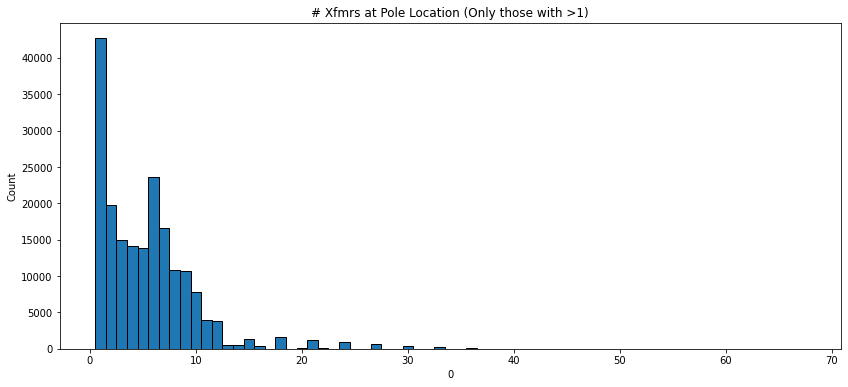

In [35]:
if merge_eemsp:
    fig,ax = Plot_General.default_subplots()
    Plot_Hist.plot_hist(
        ax=ax, 
        df=df_eemsp_reduce1.groupby('LOCATION_NB').size().to_frame(), 
        x_col=0, 
        min_max_and_bin_size=(0,10,1), 
        plot_sns=True, 
        hist_plot_kwargs=dict(discrete=True)
    )
    ax.set_title('# Xfmrs at Pole Location (Only those with >1)')

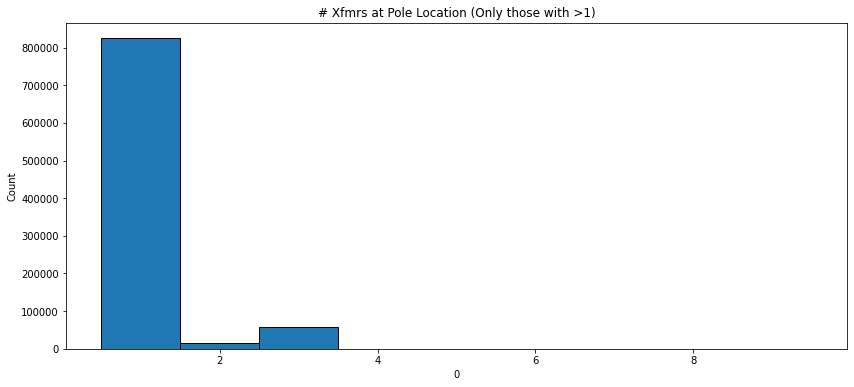

In [36]:
if merge_eemsp:
    fig,ax = Plot_General.default_subplots()
    Plot_Hist.plot_hist(
        ax=ax, 
        df=df_eemsp_reduce1.groupby(['LOCATION_NB', 'OUTG_REC_NB_TO_MERGE']).size().to_frame(), 
        x_col=0, 
        min_max_and_bin_size=(0,10,1), 
        plot_sns=True, 
        hist_plot_kwargs=dict(discrete=True)
    )
    ax.set_title('# Xfmrs at Pole Location (Only those with >1)')

In [37]:
if merge_eemsp:
    del df_eemsp_OG
    del df_eemsp_full
    del df_eemsp_reduce1
    del df_eemsp_reduce2

# TODO: Make more concrete methods for transforming install_dt

In [38]:
merged_df_full = pd.merge(
    merged_df_full, 
    Utilities_df.prepend_level_to_MultiIndex(
        df=time_infos_df,
        level_val='time_info',
        level_name=None,
        axis=1
    ), 
    left_index=True, 
    right_index=True, 
    how='left'
)
assert(merged_df_full['time_info'].isna().sum().sum()==0)
merged_df_full[('EEMSP_0', 'INSTALL_DT')] = (merged_df_full[('time_info', 't_min')] - merged_df_full[('EEMSP_0', 'INSTALL_DT')]).dt.total_seconds()/(60*60*24*365)
merged_df_full = merged_df_full.drop(columns=['time_info'])
#-------------------------
merged_df_no_outg.index.names = ['outg_rec_nb', 'trsf_pole_nb']
merged_df_no_outg = pd.merge(
    merged_df_no_outg, 
    Utilities_df.prepend_level_to_MultiIndex(
        df=time_infos_df,
        level_val='time_info',
        level_name=None,
        axis=1
    ), 
    left_index=True, 
    right_index=True, 
    how='left'
)
merged_df_no_outg.index.names = ['no_outg_rec_nb', 'trsf_pole_nb']
assert(merged_df_no_outg['time_info'].isna().sum().sum()==0)
merged_df_no_outg[('EEMSP_0', 'INSTALL_DT')] = (merged_df_no_outg[('time_info', 't_min')] - merged_df_no_outg[('EEMSP_0', 'INSTALL_DT')]).dt.total_seconds()/(60*60*24*365)
merged_df_no_outg = merged_df_no_outg.drop(columns=['time_info'])
#-------------------------
merged_df_no_outg_prstn.index.names = ['outg_rec_nb', 'trsf_pole_nb']
merged_df_no_outg_prstn = pd.merge(
    merged_df_no_outg_prstn, 
    Utilities_df.prepend_level_to_MultiIndex(
        df=time_infos_df,
        level_val='time_info',
        level_name=None,
        axis=1
    ), 
    left_index=True, 
    right_index=True, 
    how='left'
)
merged_df_no_outg_prstn.index.names = ['no_outg_rec_nb', 'trsf_pole_nb']
assert(merged_df_no_outg_prstn['time_info'].isna().sum().sum()==0)
merged_df_no_outg_prstn[('EEMSP_0', 'INSTALL_DT')] = (merged_df_no_outg_prstn[('time_info', 't_min')] - merged_df_no_outg_prstn[('EEMSP_0', 'INSTALL_DT')]).dt.total_seconds()/(60*60*24*365)
merged_df_no_outg_prstn = merged_df_no_outg_prstn.drop(columns=['time_info'])

C:\Temp/ipykernel_30336/2034662711.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_df_full = merged_df_full.drop(columns=['time_info'])
C:\Temp/ipykernel_30336/2034662711.py:33: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_df_no_outg = merged_df_no_outg.drop(columns=['time_info'])
C:\Temp/ipykernel_30336/2034662711.py:51: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_df_no_outg_prstn = merged_df_no_outg_prstn.drop(columns=['time_info'])


In [39]:
# REMOVING SCHEDULED OUTAGES

print(f'merged_df_full.shape = {merged_df_full.shape}')

merged_df_full =  MECPODf.get_cpo_df_subset_excluding_mjr_mnr_causes( 
    cpo_df=merged_df_full, 
    mjr_mnr_causes_to_exclude=None, 
    mjr_causes_to_exclude=None,
    mnr_causes_to_exclude=['SCO', 'SO'], 
    outg_rec_nb_col='index'
)

print(f'merged_df_full.shape = {merged_df_full.shape}')

merged_df_full.shape = (120359, 89)
n_coll = 11044
batch_size = 1000
n_batches = 12


C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supp

10/12


C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


merged_df_full.shape = (113881, 89)


In [40]:
merged_df_full.index.get_level_values(0).nunique()

8510

In [41]:
merged_df_full

01-06 Days                   \
                           Detected end of voltage sag Primary Power Up   
outg_rec_nb trsf_pole_nb                                                  
13273510    1831084763656                          0.0              0.0   
            1831245763849                          0.0              0.0   
            1831518763833                          0.0              0.0   
            1831636763610                          0.0              0.0   
            1831836763811                          0.0              0.0   
...                                                ...              ...   
13610644    2117114486313                          0.0              0.0   
13610648    1864592762329                          0.0              0.0   
13610670    1838722795015                          0.0              0.0   
13610714    41810727000443                         0.0              0.0   
13610730    1830661773791                          0.0              0.0   

                                               \
                           Primary Power Down   
outg_rec_nb trsf_pole_nb                        
13273510    1831084763656                 0.0   
            1831245763849                 0.0   
            1831518763833                 0.0   
            1831636763610                 0.0   
            1831836763811                 0.0   
...                                       ...   
13610644    2117114486313                 0.0   
13610648    1864592762329                 0.0   
13610670    1838722795015                 0.0   
13610714    41810727000443                0.0   
13610730    1830661773791                 0.0   

                                                                  \
                           NET_MGMT command failed consecutively   
outg_rec_nb trsf_pole_nb                                           
13273510    1831084763656                               0.000000   
            1831245763849                               0.083333   
            1831518763833                               0.000000   
            1831636763610                               0.000000   
            1831836763811                               0.000000   
...                                                          ...   
13610644    2117114486313                               0.000000   
13610648    1864592762329                               0.116667   
13610670    1838722795015                               0.000000   
13610714    41810727000443                              0.000000   
13610730    1830661773791                               0.000000   

                                                                                                        \
                           Error occurred when attempting to synch meter time with NIC time for device   
outg_rec_nb trsf_pole_nb                                                                                 
13273510    1831084763656                                            0.000000                            
            1831245763849                                            0.000000                            
            1831518763833                                            0.000000                            
            1831636763610                                            0.000000                            
            1831836763811                                            0.000000                            
...                                                                       ...                            
13610644    2117114486313                                            0.000000                            
13610648    1864592762329                                            0.033333                            
13610670    1838722795015                                            0.000000                            
13610714    41810727000443                                           0.000000    

# Add month info

In [42]:
include_month = True
summary_dict['include_month'] = include_month

if include_month:
    merged_df_full_wd = DOVSOutages.append_outg_dt_off_ts_full_to_df(
        df=merged_df_full.copy(), 
        outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
        dummy_col_levels_prefix='dummy_lvl_'
    )
    #-------------------------
    merged_df_no_outg_wd = merge_cpx_df_w_time_infos(
        cpx_df=merged_df_no_outg.copy(), 
        time_infos_df=no_outg_time_infos_df, 
        time_infos_drop_dupls_subset=['index', 't_min']
    )
    #-----
    merged_df_no_outg_prstn_wd = merge_cpx_df_w_time_infos(
        cpx_df=merged_df_no_outg_prstn.copy(), 
        time_infos_df=no_outg_time_infos_prstn_df, 
        time_infos_drop_dupls_subset=['index', 't_min']
    )
    #-------------------------
    if ('is_outg', 'is_outg') in merged_df_full_wd.columns:
        merged_df_full_wd = Utilities_df.move_cols_to_back(merged_df_full_wd, [('is_outg', 'is_outg')])
    if ('is_outg', 'is_outg') in merged_df_no_outg_wd.columns:
        merged_df_no_outg_wd = Utilities_df.move_cols_to_back(merged_df_no_outg_wd, [('is_outg', 'is_outg')])
    if ('is_outg', 'is_outg') in merged_df_no_outg_prstn_wd.columns:
        merged_df_no_outg_prstn_wd = Utilities_df.move_cols_to_back(merged_df_no_outg_prstn_wd, [('is_outg', 'is_outg')])
    #-------------------------
    # Change outage time to just month of outage
    merged_df_full_wd[('dummy_lvl_0', 'outg_month')] = merged_df_full_wd[('dummy_lvl_0', 'DT_OFF_TS_FULL')].dt.month

    merged_df_no_outg_wd[('dummy_lvl_0', 'outg_month')] = merged_df_no_outg_wd[('dummy_lvl_0', 't_min')].dt.month
    merged_df_no_outg_prstn_wd[('dummy_lvl_0', 'outg_month')] = merged_df_no_outg_prstn_wd[('dummy_lvl_0', 't_min')].dt.month

    #-------------------------
    merged_df_full_wd = merged_df_full_wd.drop(columns=[('dummy_lvl_0', 'DT_OFF_TS_FULL')])
    merged_df_no_outg_wd = merged_df_no_outg_wd.drop(columns=[('dummy_lvl_0', 't_min'), ('dummy_lvl_0', 't_max'), ('dummy_lvl_0', 'prem_nbs')])
    merged_df_no_outg_prstn_wd = merged_df_no_outg_prstn_wd.drop(columns=[('dummy_lvl_0', 't_min'), ('dummy_lvl_0', 't_max'), ('dummy_lvl_0', 'prem_nbs')])
    #-------------------------
    merged_df_full=merged_df_full_wd.copy()
    merged_df_no_outg=merged_df_no_outg_wd.copy()
    merged_df_no_outg_prstn=merged_df_no_outg_prstn_wd.copy()

C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supp

# !~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~

In [43]:
# Remove NETWORK and PRIMARY trsf_pole_nbs
# merged_df_no_outg=merged_df_no_outg.loc[~merged_df_no_outg.index.get_level_values(0).isin(['NETWORK', 'PRIMARY'])]
# merged_df_no_outg_prstn=merged_df_no_outg_prstn.loc[~merged_df_no_outg_prstn.index.get_level_values(0).isin(['NETWORK', 'PRIMARY'])]
merged_df_no_outg=merged_df_no_outg.loc[~merged_df_no_outg.index.get_level_values(1).isin(['NETWORK', 'PRIMARY'])]
merged_df_no_outg_prstn=merged_df_no_outg_prstn.loc[~merged_df_no_outg_prstn.index.get_level_values(1).isin(['NETWORK', 'PRIMARY'])]
#-----
merged_df_full=merged_df_full[~merged_df_full.index.get_level_values(1).isin(['NETWORK', 'PRIMARY'])]

In [44]:
# Get DOVS info to be used for setting target values
merged_df_full_w_DOVS = DOVSOutages.append_outg_info_to_df(
    df=merged_df_full.copy(), 
    outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
    build_sql_function=DOVSOutages_SQL.build_sql_std_outage, 
)
merged_df_full_w_DOVS=merged_df_full_w_DOVS[['outg_dummy_lvl_0']]
merged_df_full_w_DOVS[('is_outg', 'is_outg')]=0

C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supp

In [45]:
# Add 'from_outg' information so I can track how many are in target=1 and target=0 
merged_df_full[('from_outg', 'from_outg')]          = 1
merged_df_no_outg[('from_outg', 'from_outg')]       = 0
merged_df_no_outg_prstn[('from_outg', 'from_outg')] = 0

In [46]:
an_keys

['01-06 Days',
 '06-11 Days',
 '11-16 Days',
 '16-21 Days',
 '21-26 Days',
 '26-31 Days']

# Drop any time periods

In [47]:
an_keys_to_drop = None
# an_keys_to_drop = ['00-01 Days']
# an_keys_to_drop = ['01-06 Days']

summary_dict['an_keys_to_drop'] = an_keys_to_drop

In [48]:
if an_keys_to_drop is not None:
    merged_df_full          = merged_df_full.drop(columns=an_keys_to_drop, level=0)
    merged_df_no_outg       = merged_df_no_outg.drop(columns=an_keys_to_drop, level=0)
    merged_df_no_outg_prstn = merged_df_no_outg_prstn.drop(columns=an_keys_to_drop, level=0)

In [ ]:
date_0_train   = pd.to_datetime('2021-01-01')
date_1_train   = pd.to_datetime('2022-01-01')
#-----
date_0_test    = pd.to_datetime('2022-01-01')
date_1_test    = pd.to_datetime('2023-01-01')
#-----
date_0_HOLDOUT = pd.to_datetime('2022-06-01')
date_1_HOLDOUT = pd.to_datetime('2023-01-01')

# date_0_train   = pd.to_datetime('2021-01-01')
# date_1_train   = pd.to_datetime('2022-01-01')
# #-----
# date_0_test    = pd.to_datetime('2022-01-01')
# date_1_test    = pd.to_datetime('2022-06-01')
# #-----
# date_0_HOLDOUT = pd.to_datetime('2022-06-01')
# date_1_HOLDOUT = pd.to_datetime('2023-01-01')

# date_0_train   = pd.to_datetime('2020-01-01')
# date_1_train   = pd.to_datetime('2022-01-01')
# #-----
# date_0_test    = pd.to_datetime('2022-01-01')
# date_1_test    = pd.to_datetime('2022-01-01')
# #-----
# date_0_HOLDOUT = pd.to_datetime('2022-01-01')
# date_1_HOLDOUT = pd.to_datetime('2023-01-01')

In [ ]:
get_train_test_by_date = False
split_train_test_by_outg = True 
random_state = None
test_size=0.33

In [ ]:
# NOTE: Timestamp is not JSON serializable, hence the need for strftime below
summary_dict['date_0_train'] = date_0_train.strftime('%Y-%m-%d %H:%M:%S')
summary_dict['date_1_train'] = date_1_train.strftime('%Y-%m-%d %H:%M:%S')
#-----
summary_dict['date_0_test'] = date_0_test.strftime('%Y-%m-%d %H:%M:%S')
summary_dict['date_1_test'] = date_1_test.strftime('%Y-%m-%d %H:%M:%S')
#-----
summary_dict['date_0_HOLDOUT'] = date_0_HOLDOUT.strftime('%Y-%m-%d %H:%M:%S')
summary_dict['date_1_HOLDOUT'] = date_1_HOLDOUT.strftime('%Y-%m-%d %H:%M:%S')
#-----
summary_dict['get_train_test_by_date'] = get_train_test_by_date
summary_dict['split_train_test_by_outg'] = split_train_test_by_outg
#-----
summary_dict['random_state'] = random_state
summary_dict['test_size'] = test_size

In [ ]:
if get_train_test_by_date:
    merged_df_full_train = get_cpx_outg_df_subset_by_outg_datetime(
        cpx_outg_df=merged_df_full.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_train, 
        outg_rec_nb_idfr='index', 
        return_notin_also=False
    )
    merged_df_full_test = get_cpx_outg_df_subset_by_outg_datetime(
        cpx_outg_df=merged_df_full.copy(), 
        date_0 = date_0_test,
        date_1 = date_1_test, 
        outg_rec_nb_idfr='index', 
        return_notin_also=False
    )
else:
    merged_df_full_train_test = get_cpx_outg_df_subset_by_outg_datetime(
        cpx_outg_df=merged_df_full.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_test, 
        outg_rec_nb_idfr='index', 
        return_notin_also=False
    )
    #-----
    if split_train_test_by_outg:
        merged_df_full_train, merged_df_full_test = train_test_split_df_by_outage(
            df=merged_df_full_train_test, 
            outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
            test_size=test_size, 
            random_state=random_state
        )
    else:
        merged_df_full_train, merged_df_full_test = train_test_split(
            merged_df_full_train_test, 
            test_size=test_size, 
            random_state=random_state
        )
#-------------------------    
merged_df_full_HOLDOUT = get_cpx_outg_df_subset_by_outg_datetime(
    cpx_outg_df=merged_df_full.copy(), 
    date_0 = date_0_HOLDOUT,
    date_1 = date_1_HOLDOUT, 
    outg_rec_nb_idfr='index', 
    return_notin_also=False
)

In [ ]:
if get_train_test_by_date:
    merged_df_no_outg_train = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg.copy(), 
        bsln_time_infos_df = no_outg_time_infos_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_train, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    merged_df_no_outg_test = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg.copy(), 
        bsln_time_infos_df = no_outg_time_infos_df.copy(), 
        date_0 = date_0_test,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
else:
    merged_df_no_outg_train_test = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg.copy(), 
        bsln_time_infos_df = no_outg_time_infos_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    #-----
    if split_train_test_by_outg:
        merged_df_no_outg_train, merged_df_no_outg_test = train_test_split_df_by_outage(
            df=merged_df_no_outg_train_test, 
            outg_rec_nb_idfr=('index', 'no_outg_rec_nb'), 
            test_size=test_size, 
            random_state=random_state
        )
    else:
        merged_df_no_outg_train, merged_df_no_outg_test = train_test_split(
            merged_df_no_outg_train_test, 
            test_size=test_size, 
            random_state=random_state
        )
#-------------------------   
merged_df_no_outg_HOLDOUT = get_cpx_baseline_df_subset_by_datetime(
    cpx_bsln_df = merged_df_no_outg.copy(), 
    bsln_time_infos_df = no_outg_time_infos_df.copy(), 
    date_0 = date_0_HOLDOUT,
    date_1 = date_1_HOLDOUT, 
    bsln_time_infos_time_col='t_min', 
    return_notin_also=False, 
    merge_time_info_to_cpx_bsln_df=False
)
#--------------------------------------------------   
if get_train_test_by_date:
    merged_df_no_outg_prstn_train = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
        bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_train, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    merged_df_no_outg_prstn_test = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
        bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
        date_0 = date_0_test,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
else:
    merged_df_no_outg_prstn_train_test = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
        bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    if split_train_test_by_outg:
        merged_df_no_outg_prstn_train, merged_df_no_outg_prstn_test = train_test_split(
            merged_df_no_outg_prstn_train_test, 
            test_size=test_size, 
            random_state=random_state
        )
    else:
        merged_df_no_outg_prstn_train, merged_df_no_outg_prstn_test = train_test_split_df_by_outage(
            df=merged_df_no_outg_prstn_train_test, 
            outg_rec_nb_idfr=('index', 'no_outg_rec_nb'), 
            test_size=test_size, 
            random_state=random_state
        )
#-------------------------   
merged_df_no_outg_prstn_HOLDOUT = get_cpx_baseline_df_subset_by_datetime(
    cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
    bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
    date_0 = date_0_HOLDOUT,
    date_1 = date_1_HOLDOUT, 
    bsln_time_infos_time_col='t_min', 
    return_notin_also=False, 
    merge_time_info_to_cpx_bsln_df=False
)

In [ ]:
addtnl_baseline_train = pd.concat([merged_df_no_outg_train, merged_df_no_outg_prstn_train])
# addtnl_baseline_train = addtnl_baseline_train.sample(frac=0.10)

addtnl_baseline_test = pd.concat([merged_df_no_outg_test, merged_df_no_outg_prstn_test])
# addtnl_baseline_test = addtnl_baseline_test.sample(frac=0.10)

addtnl_baseline_HOLDOUT = pd.concat([merged_df_no_outg_HOLDOUT, merged_df_no_outg_prstn_HOLDOUT])
# addtnl_baseline_HOLDOUT = addtnl_baseline_HOLDOUT.sample(frac=0.10)

In [ ]:
full_data_df_train   = pd.concat([merged_df_full_train, addtnl_baseline_train])
full_data_df_test    = pd.concat([merged_df_full_test, addtnl_baseline_test])
full_data_df_HOLDOUT = pd.concat([merged_df_full_HOLDOUT, addtnl_baseline_HOLDOUT])

#Shuffle the data
full_data_df_train   = full_data_df_train.sample(frac=1)
full_data_df_test    = full_data_df_test.sample(frac=1)
full_data_df_HOLDOUT = full_data_df_HOLDOUT.sample(frac=1)

full_data_df = pd.concat([full_data_df_train, full_data_df_test, full_data_df_HOLDOUT])

# =========================================================
# =========================================================

In [ ]:
#NOTE!!!!!!!!!!!!!
# If using _v2, SHOULD NOT SCALE events_period column!!!!!!!!!!!!

create_validation_set = False
val_size = 0.10 #w.r.t to train size (i.e., w.r.t 1.0-test_size)

run_scaler=True

run_PCA = False
pca_n_components=0.95

In [ ]:
summary_dict['create_validation_set'] = create_validation_set
summary_dict['val_size']              = val_size
summary_dict['run_scaler']            = run_scaler
summary_dict['run_PCA']               = run_PCA
summary_dict['pca_n_components']      = pca_n_components

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
if merge_eemsp:
    cols_to_encode = full_data_df['EEMSP_0'].columns
    numeric_cols = ['KVA_SIZE', 'INSTALL_DT']
    cols_to_encode = [('EEMSP_0', x) for x in cols_to_encode if x not in numeric_cols]
    #-------------------------
    full_data_df[cols_to_encode]         = full_data_df[cols_to_encode].astype(str)
    full_data_df_train[cols_to_encode]   = full_data_df_train[cols_to_encode].astype(str)
    full_data_df_test[cols_to_encode]    = full_data_df_test[cols_to_encode].astype(str)
    full_data_df_HOLDOUT[cols_to_encode] = full_data_df_HOLDOUT[cols_to_encode].astype(str)
    #-------------------------
    eemsp_enc = preprocessing.OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1
    )
    # NOTE: In order for eemsp_enc to include the feature_names_in_ attribute (which I would like to use
    #         in model deployment to ensure the EEMSP data form matches that expected by eemsp_end), the
    #         feature names must be string.
    #       Hence the need for .droplevel(0, axis=1) below (the use within the transform call is not strictly
    #         needed, but prevents a warning message from being output)
    eemsp_enc.fit(full_data_df[cols_to_encode].droplevel(0, axis=1))
    #-----
    full_data_df_train[cols_to_encode]   = eemsp_enc.transform(full_data_df_train[cols_to_encode].droplevel(0, axis=1))
    full_data_df_test[cols_to_encode]    = eemsp_enc.transform(full_data_df_test[cols_to_encode].droplevel(0, axis=1))
    full_data_df_HOLDOUT[cols_to_encode] = eemsp_enc.transform(full_data_df_HOLDOUT[cols_to_encode].droplevel(0, axis=1))
    #-------------------------
    if save_results:
        joblib.dump(eemsp_enc, os.path.join(save_dir_model, 'eemsp_encoder.joblib'))

In [ ]:
# # if merge_eemsp:
# #     full_data_df         = full_data_df.drop(columns=[('key_0', '')])
# #     full_data_df_train   = full_data_df_train.drop(columns=[('key_0', '')])
# #     full_data_df_test    = full_data_df_test.drop(columns=[('key_0', '')])
# #     full_data_df_HOLDOUT = full_data_df_HOLDOUT.drop(columns=[('key_0', '')])
    
# #     le = preprocessing.LabelEncoder()
# #     cols_to_encode = full_data_df['EEMSP'].columns
# #     for col in cols_to_encode:
# #         le.fit(full_data_df[('EEMSP', col)])
# #         #-----
# #         full_data_df_train[('EEMSP', col)]   = le.transform(full_data_df_train[('EEMSP', col)])
# #         full_data_df_test[('EEMSP', col)]    = le.transform(full_data_df_test[('EEMSP', col)])
# #         full_data_df_HOLDOUT[('EEMSP', col)] = le.transform(full_data_df_HOLDOUT[('EEMSP', col)])

# if merge_eemsp:
#     eemsp_label_encoders = dict()
#     cols_to_encode = full_data_df['EEMSP_0'].columns
#     numeric_cols = ['KVA_SIZE', 'INSTALL_DT']
#     cols_to_encode = [x for x in cols_to_encode if x not in numeric_cols]
#     for col in cols_to_encode:
#         le = preprocessing.LabelEncoder()
#         #-----
#         full_data_df[('EEMSP_0', col)]         = full_data_df[('EEMSP_0', col)].astype(str)
#         full_data_df_train[('EEMSP_0', col)]   = full_data_df_train[('EEMSP_0', col)].astype(str)
#         full_data_df_test[('EEMSP_0', col)]    = full_data_df_test[('EEMSP_0', col)].astype(str)
#         full_data_df_HOLDOUT[('EEMSP_0', col)] = full_data_df_HOLDOUT[('EEMSP_0', col)].astype(str)
#         #-----
#         le.fit(full_data_df[('EEMSP_0', col)])
#         #-----
#         full_data_df_train[('EEMSP_0', col)]   = le.transform(full_data_df_train[('EEMSP_0', col)])
#         full_data_df_test[('EEMSP_0', col)]    = le.transform(full_data_df_test[('EEMSP_0', col)])
#         full_data_df_HOLDOUT[('EEMSP_0', col)] = le.transform(full_data_df_HOLDOUT[('EEMSP_0', col)])
#         #-----
#         assert(col not in eemsp_label_encoders.keys())
#         eemsp_label_encoders[col] = le
        
#     if save_results:
#         with open(os.path.join(save_dir_model, 'eemsp_label_encoders.pkl'), 'wb') as handle:
#             pickle.dump(eemsp_label_encoders, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Set target values

In [ ]:
# fig_save_dir_base = r'C:\Users\s346557\Documents\AnalysisNote\X_Results\X_2_OutageMeterEvents\Figures\ConfusionMatrices'
# # fig_save_subdir = 'Target_eq_1_ALL_w_EEMSP'
# fig_save_subdir = 'Target_eq_1_ALL'
# # fig_save_subdir = 'trsf_nb_eq_LocID_w_EEMSP'
# fig_save_dir = os.path.join(fig_save_dir_base, fig_save_subdir)

In [ ]:
merged_df_full_w_DOVS

In [ ]:
outg_n_xfmrs = get_n_trsf_poles_per_outg(
    df=merged_df_full, 
    outg_rec_nb_idfr='index_0', 
    trsf_pole_nb_idfr='index_1'
)
outgs_w_single_xfmr = outg_n_xfmrs[outg_n_xfmrs==1].index.tolist()
#-------------------------

In [ ]:
xfmr_equip_typ_nms_of_interest = ['TRANSFORMER, OH', 'TRANSFORMER, UG']
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'LOCATION_ID'), 
#             value=merged_df_full_w_DOVS.index.get_level_values(1), 
#             comparison_operator='=='
#         ), 
#         dict(
#             column=('outg_dummy_lvl_0', 'EQUIP_TYP_NM'), 
#             value=xfmr_equip_typ_nms_of_interest, 
#             comparison_operator='isin'
#         )
#     ]
# )
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'LOCATION_ID'), 
#             value=merged_df_full_w_DOVS.index.get_level_values(1), 
#             comparison_operator='=='
#         )
#     ]
# )
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'MNR_CAUSE_NM'), 
#             value='EQUIPMENT FAILURE', 
#             comparison_operator='=='
#         )
#     ]
# )
#-----
slicer = DFSlicer()
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'EQUIP_TYP_NM'), 
#             value='CONDUCTOR OVERHEAD', 
#             comparison_operator='=='
#         )
#     ]
# )
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'LOCATION_ID'), 
#             value=merged_df_full_w_DOVS.index.get_level_values(1), 
#             comparison_operator='=='
#         ), 
#         dict(
#             column=('outg_dummy_lvl_0', 'OUTG_REC_NB'), 
#             value=outgs_w_single_xfmr, 
#             comparison_operator='isin'
#         )
#     ]
# )
# merged_df_full_w_DOVS[('outg_dummy_lvl_0', 'OUTG_REC_NB')] = merged_df_full_w_DOVS.index.get_level_values(0)
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'MJR_CAUSE_NM'), 
#             value='DISTRIBUTION LINE', 
#             comparison_operator='=='
#         ), 
#         dict(
#             column=('outg_dummy_lvl_0', 'MNR_CAUSE_NM'), 
#             value='EQUIPMENT FAILURE', 
#             comparison_operator='=='
#         )
#     ]
# )

In [ ]:
summary_dict['slicer'] = slicer.as_dict()

In [ ]:
merged_df_full_w_DOVS_i = slicer.set_simple_column_value(df=merged_df_full_w_DOVS.copy(), column=('is_outg', 'is_outg'), value=1)
full_outg_idxs_i = merged_df_full_w_DOVS_i[merged_df_full_w_DOVS_i[('is_outg', 'is_outg')]==1].index

#NOTE: To achieve exclusion equal to that in set_target_val_1_by_idx, one could use:
#        full_outg_idxs_exclude_i = merged_df_full_w_DOVS_i[merged_df_full_w_DOVS_i[('is_outg', 'is_outg')]==0].index
#      then use .drop(index=list(set(full_data_df_i.index).intersection(set(full_outg_idxs_exclude_i))))
#      However, as noted in the function, the methods in set_target_val_1_by_idx are probably safer/more robust

In [ ]:
remove_others_from_outages=False
summary_dict['remove_others_from_outages'] = remove_others_from_outages
#-------------------------
full_data_df_i         = full_data_df.copy()
full_data_df_train_i   = full_data_df_train.copy()
full_data_df_test_i    = full_data_df_test.copy()
full_data_df_HOLDOUT_i = full_data_df_HOLDOUT.copy()
#-------------------------
full_data_df_i = set_target_val_1_by_idx(
    df=full_data_df_i,
    val_1_idxs=full_outg_idxs_i,
    remove_others_from_outages=remove_others_from_outages, 
    target_col=('is_outg', 'is_outg'), 
    from_outg_col=('from_outg', 'from_outg')
)
#-----
full_data_df_train_i = set_target_val_1_by_idx(
    df=full_data_df_train_i,
    val_1_idxs=full_outg_idxs_i,
    remove_others_from_outages=remove_others_from_outages, 
    target_col=('is_outg', 'is_outg'), 
    from_outg_col=('from_outg', 'from_outg')
)
#-----
full_data_df_test_i = set_target_val_1_by_idx(
    df=full_data_df_test_i,
    val_1_idxs=full_outg_idxs_i,
    remove_others_from_outages=remove_others_from_outages, 
    target_col=('is_outg', 'is_outg'), 
    from_outg_col=('from_outg', 'from_outg')
)
#-----
full_data_df_HOLDOUT_i = set_target_val_1_by_idx(
    df=full_data_df_HOLDOUT_i,
    val_1_idxs=full_outg_idxs_i,
    remove_others_from_outages=remove_others_from_outages, 
    target_col=('is_outg', 'is_outg'), 
    from_outg_col=('from_outg', 'from_outg')
)

In [ ]:
#--------------------------------------------------
n_outg_target_1_train = full_data_df_train_i[('is_outg', 'is_outg')].sum()
n_outg_target_0_train = full_data_df_train_i[
    (full_data_df_train_i[('from_outg', 'from_outg')]==1) & 
    (full_data_df_train_i[('is_outg', 'is_outg')]==0)
].shape[0]
n_bsln_train = full_data_df_train_i[full_data_df_train_i[('from_outg', 'from_outg')]==0].shape[0]
assert(full_data_df_train_i.shape[0]==n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
pct_target_1_train = 100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
#-----
print('\n----- TRAIN -----')
print(f"# direct outages (target = 1):      {n_outg_target_1_train}")
print(f"# indirect outages (target = 0):    {n_outg_target_0_train}")
print(f"\t% direct = {100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train)}")
print(f"# additional baseline (target = 0): {n_bsln_train}")
print(f"%(target==1):                       {pct_target_1_train}%")

#--------------------------------------------------
n_outg_target_1_test = full_data_df_test_i[('is_outg', 'is_outg')].sum()
n_outg_target_0_test = full_data_df_test_i[
    (full_data_df_test_i[('from_outg', 'from_outg')]==1) & 
    (full_data_df_test_i[('is_outg', 'is_outg')]==0)
].shape[0]
n_bsln_test = full_data_df_test_i[full_data_df_test_i[('from_outg', 'from_outg')]==0].shape[0]
assert(full_data_df_test_i.shape[0]==n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
pct_target_1_test = 100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
#-----
print('\n----- TEST -----')
print(f"# direct outages (target = 1):      {n_outg_target_1_test}")
print(f"# indirect outages (target = 0):    {n_outg_target_0_test}")
print(f"\t% direct = {100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test)}")
print(f"# additional baseline (target = 0): {n_bsln_test}")
print(f"%(target==1):                       {pct_target_1_test}%")

#--------------------------------------------------
n_outg_target_1_HOLDOUT = full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()
n_outg_target_0_HOLDOUT = full_data_df_HOLDOUT_i[
    (full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==1) & 
    (full_data_df_HOLDOUT_i[('is_outg', 'is_outg')]==0)
].shape[0]
n_bsln_HOLDOUT = full_data_df_HOLDOUT_i[full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==0].shape[0]
assert(full_data_df_HOLDOUT_i.shape[0]==n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
pct_target_1_HOLDOUT = 100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
#-----
print('\n----- HOLDOUT -----')
print(f"# direct outages (target = 1):      {n_outg_target_1_HOLDOUT}")
print(f"# indirect outages (target = 0):    {n_outg_target_0_HOLDOUT}")
print(f"\t% direct = {100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT)}")
print(f"# additional baseline (target = 0): {n_bsln_HOLDOUT}")
print(f"%(target==1):                       {pct_target_1_HOLDOUT}%")

In [ ]:
if (
    full_data_df_train_i[('is_outg', 'is_outg')].sum()==0 or 
    full_data_df_test_i[('is_outg', 'is_outg')].sum()==0 or 
    full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()==0
):
    print('Not enough target value==1 in train, test, and/or holdout')
    print(f"#target==1 train:   {full_data_df_train_i[('is_outg', 'is_outg')].sum()}")
    print(f"#target==1 test:    {full_data_df_test_i[('is_outg', 'is_outg')].sum()}")
    print(f"#target==1 holdout: {full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()}")

In [ ]:
full_data_df_train_i

In [ ]:
# min_pct_target_1 = 25
min_pct_target_1 = None
summary_dict['min_pct_target_1'] = min_pct_target_1
if min_pct_target_1 is not None:
    full_data_df_train_i = ensure_target_val_1_min_pct(
        df=full_data_df_train_i,
        min_pct=min_pct_target_1,
        target_col=('is_outg', 'is_outg'), 
        random_state=random_state, 
        return_discarded=False
    )
    #-----
    full_data_df_test_i = ensure_target_val_1_min_pct(
        df=full_data_df_test_i,
        min_pct=min_pct_target_1,
        target_col=('is_outg', 'is_outg'), 
        random_state=random_state, 
        return_discarded=False
    )
    #-----
    full_data_df_HOLDOUT_i = ensure_target_val_1_min_pct(
        df=full_data_df_HOLDOUT_i,
        min_pct=min_pct_target_1,
        target_col=('is_outg', 'is_outg'), 
        random_state=random_state, 
        return_discarded=False
    )
    #-----

In [ ]:
#--------------------------------------------------
n_outg_target_1_train = full_data_df_train_i[('is_outg', 'is_outg')].sum()
n_outg_target_0_train = full_data_df_train_i[
    (full_data_df_train_i[('from_outg', 'from_outg')]==1) & 
    (full_data_df_train_i[('is_outg', 'is_outg')]==0)
].shape[0]
n_bsln_train = full_data_df_train_i[full_data_df_train_i[('from_outg', 'from_outg')]==0].shape[0]
assert(full_data_df_train_i.shape[0]==n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
pct_target_1_train = 100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
#-----
print('\n----- TRAIN -----')
print(f"# direct outages (target = 1):      {n_outg_target_1_train}")
print(f"# indirect outages (target = 0):    {n_outg_target_0_train}")
print(f"\t% direct = {100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train)}")
print(f"# additional baseline (target = 0): {n_bsln_train}")
print(f"%(target==1):                       {pct_target_1_train}%")

#--------------------------------------------------
n_outg_target_1_test = full_data_df_test_i[('is_outg', 'is_outg')].sum()
n_outg_target_0_test = full_data_df_test_i[
    (full_data_df_test_i[('from_outg', 'from_outg')]==1) & 
    (full_data_df_test_i[('is_outg', 'is_outg')]==0)
].shape[0]
n_bsln_test = full_data_df_test_i[full_data_df_test_i[('from_outg', 'from_outg')]==0].shape[0]
assert(full_data_df_test_i.shape[0]==n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
pct_target_1_test = 100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
#-----
print('\n----- TEST -----')
print(f"# direct outages (target = 1):      {n_outg_target_1_test}")
print(f"# indirect outages (target = 0):    {n_outg_target_0_test}")
print(f"\t% direct = {100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test)}")
print(f"# additional baseline (target = 0): {n_bsln_test}")
print(f"%(target==1):                       {pct_target_1_test}%")

#--------------------------------------------------
n_outg_target_1_HOLDOUT = full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()
n_outg_target_0_HOLDOUT = full_data_df_HOLDOUT_i[
    (full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==1) & 
    (full_data_df_HOLDOUT_i[('is_outg', 'is_outg')]==0)
].shape[0]
n_bsln_HOLDOUT = full_data_df_HOLDOUT_i[full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==0].shape[0]
assert(full_data_df_HOLDOUT_i.shape[0]==n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
pct_target_1_HOLDOUT = 100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
#-----
print('\n----- HOLDOUT -----')
print(f"# direct outages (target = 1):      {n_outg_target_1_HOLDOUT}")
print(f"# indirect outages (target = 0):    {n_outg_target_0_HOLDOUT}")
print(f"\t% direct = {100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT)}")
print(f"# additional baseline (target = 0): {n_bsln_HOLDOUT}")
print(f"%(target==1):                       {pct_target_1_HOLDOUT}%")

In [ ]:
if ('from_outg', 'from_outg') in full_data_df_i.columns.tolist():
    full_data_df_i = full_data_df_i.drop(columns=[('from_outg', 'from_outg')])
if ('from_outg', 'from_outg') in full_data_df_train_i.columns.tolist():
    full_data_df_train_i = full_data_df_train_i.drop(columns=[('from_outg', 'from_outg')])
if ('from_outg', 'from_outg') in full_data_df_test_i.columns.tolist():
    full_data_df_test_i = full_data_df_test_i.drop(columns=[('from_outg', 'from_outg')])
if ('from_outg', 'from_outg') in full_data_df_HOLDOUT_i.columns.tolist():
    full_data_df_HOLDOUT_i = full_data_df_HOLDOUT_i.drop(columns=[('from_outg', 'from_outg')])

In [ ]:
reduce_train_size = False
red_test_size = 0.75 #Amount kept will be 1.0-red_test_size
summary_dict['reduce_train_size'] = reduce_train_size
summary_dict['red_test_size'] = red_test_size
if reduce_train_size:
    if split_train_test_by_outg:
        full_data_df_train_i, _ = train_test_split_df_by_outage(
            df=full_data_df_train_i, 
            outg_rec_nb_idfr='index_0', 
            test_size=red_test_size, 
            random_state=random_state
        )
    else:
        full_data_df_train_i, _ = train_test_split(
            full_data_df_train_i, 
            test_size=red_test_size, 
            random_state=random_state
        )

# Prepare Data

In [ ]:
full_data_df_train_i.isna().sum()

In [ ]:
ugh = full_data_df_train_i.isna().sum()

In [ ]:
ugh[ugh>0]

In [ ]:
print(full_data_df_train_i.shape[0])
full_data_df_train_i = full_data_df_train_i.dropna()
print(full_data_df_train_i.shape[0])
print()
#-----
print(full_data_df_test_i.shape[0])
full_data_df_test_i = full_data_df_test_i.dropna()
print(full_data_df_test_i.shape[0])
print()
#-----
print(full_data_df_HOLDOUT_i.shape[0])
full_data_df_HOLDOUT_i = full_data_df_HOLDOUT_i.dropna()
print(full_data_df_HOLDOUT_i.shape[0])
print()
#-----

In [ ]:
full_data_df_test_i

In [ ]:
full_data_df_HOLDOUT_i

In [ ]:
# full_data_df_train_i   = full_data_df_train_i.drop(columns=('dummy_lvl_0', 'outg_month'))
# full_data_df_test_i    = full_data_df_test_i.drop(columns=('dummy_lvl_0', 'outg_month'))
# full_data_df_HOLDOUT_i = full_data_df_HOLDOUT_i.drop(columns=('dummy_lvl_0', 'outg_month'))

In [ ]:
set(full_data_df_train_i.columns.tolist()).symmetric_difference(set(full_data_df.columns.tolist()))

In [ ]:
#-------------------------
X_train_OG = full_data_df_train_i.iloc[:, :-1].copy()
y_train    = full_data_df_train_i.iloc[:, -1].copy()

X_test_OG = full_data_df_test_i.iloc[:, :-1].copy()
y_test    = full_data_df_test_i.iloc[:, -1].copy()

X_HOLDOUT = full_data_df_HOLDOUT_i.iloc[:, :-1]
y_HOLDOUT = full_data_df_HOLDOUT_i.iloc[:, -1]

In [ ]:
if save_results:
    X_train_OG.head().to_pickle(os.path.join(save_dir_model, 'data_structure_df.pkl'))

In [ ]:
fig, axs = Plot_General.default_subplots(2,2, return_flattened_axes=True)
#-------------------------
sns.countplot(ax=axs[0], x = ('is_outg', 'is_outg'), data=full_data_df_i)
axs[0].set_title('Full Data');
axs[0].set_xlabel('Is Outage');
axs[0].set_ylim([1.05*x for x in axs[0].get_ylim()])
for p in axs[0].patches:
    pct = (p.get_height()/full_data_df_i.shape[0]).round(5)
    txt = f'{pct}%'
    txt_x = p.get_x() 
    txt_y = 1.025*p.get_height()
    axs[0].text(txt_x,txt_y,txt)
#-------------------------
sns.countplot(ax=axs[1], x = ('is_outg', 'is_outg'), data=y_train.to_frame())
axs[1].set_title('Training Data');
axs[1].set_xlabel('Is Outage');
axs[1].set_ylim([1.05*x for x in axs[1].get_ylim()])
for p in axs[1].patches:
    pct = (p.get_height()/y_train.shape[0]).round(5)
    txt = f'{pct}%'
    txt_x = p.get_x() 
    txt_y = 1.025*p.get_height()
    axs[1].text(txt_x,txt_y,txt)
#-------------------------
sns.countplot(ax=axs[2], x = ('is_outg', 'is_outg'), data=y_test.to_frame())
axs[2].set_title('Testing Data');
axs[2].set_xlabel('Is Outage');
axs[2].set_ylim([1.05*x for x in axs[2].get_ylim()])
for p in axs[2].patches:
    pct = (p.get_height()/y_test.shape[0]).round(5)
    txt = f'{pct}%'
    txt_x = p.get_x() 
    txt_y = 1.025*p.get_height()
    axs[2].text(txt_x,txt_y,txt)
#-------------------------
sns.countplot(ax=axs[3], x = ('is_outg', 'is_outg'), data=y_HOLDOUT.to_frame())
axs[3].set_title('Holdout Data');
axs[3].set_xlabel('Is Outage');
axs[3].set_ylim([1.05*x for x in axs[3].get_ylim()])
for p in axs[3].patches:
    pct = (p.get_height()/y_HOLDOUT.shape[0]).round(5)
    txt = f'{pct}%'
    txt_x = p.get_x() 
    txt_y = 1.025*p.get_height()
    axs[3].text(txt_x,txt_y,txt)

In [ ]:
create_validation_set

In [ ]:
run_PCA

In [ ]:
run_scaler

In [ ]:
#-------------------------
if create_validation_set:
    if split_train_test_by_outg:
        X_train_OG, X_val_OG, y_train, y_val = train_test_split_df_group(
            X=X_train_OG, 
            y=y_train, 
            groups=X_train_OG.index.get_level_values(0), 
            test_size=val_size, 
            random_state=random_state
        )
    else:
        X_train_OG, X_val_OG, y_train, y_val = train_test_split(X_train_OG, y_train, test_size=val_size, random_state=random_state)
#-------------------------
if run_scaler:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_OG)
    #-----
    if create_validation_set:
        X_val   = scaler.transform(X_val_OG)
    X_test  = scaler.transform(X_test_OG)
    X_HOLDOUT   = scaler.transform(X_HOLDOUT)
else:
    X_train = X_train_OG
    if create_validation_set:
        X_val   = X_val_OG
    X_test  = X_test_OG

In [ ]:
X_train_OG

In [ ]:
X_train.shape

In [ ]:
X_train

In [ ]:
if run_PCA:
    # First, generate a PCA plot, showing the explained variance on the y-axis and number of components on x
    # This is simply to check that the number of components kept looks correct
    pca = PCA()
    pca.fit(X_train)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(cumsum)
    
    # Now, run the PCA with pca_n_components and perform transforms
    pca=PCA(n_components=pca_n_components)
    X_train = pca.fit_transform(X_train)
    print(f'PCA n-components       = {pca.n_components_}')
    print(f'PCA explained variance = {pca.explained_variance_ratio_.sum()}')
    #-----
    if create_validation_set:
        X_val      = pca.transform(X_val)
    X_test     = pca.transform(X_test)
    X_HOLDOUT  = pca.transform(X_HOLDOUT)

In [ ]:
X_train.shape

# BEG DEL

In [ ]:
full_data_df

In [ ]:
(full_data_df.columns.get_level_values(0).unique().tolist())

In [ ]:
(full_data_df.columns.get_level_values(1).unique().tolist())

In [ ]:
natsorted(full_data_df['EEMSP_0'].columns.get_level_values(0).unique().tolist())

# END DEL

# Dumb Classifier

In [ ]:
dumb_clf = DumbClassifier()
cross_val_score(dumb_clf, X_train, y_train, cv=3, scoring='accuracy')

In [ ]:
# y_pred = dumb_clf.predict(X_test)
# print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
# print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
# print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))

In [ ]:
# confusion_matrix(y_test, y_pred)

# Random Forest

In [ ]:
# forest_clf = RandomForestClassifier(n_estimators = 100)
# forest_clf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
# forest_clf = RandomForestClassifier(n_estimators = 1000, criterion='entropy', n_jobs=-1)

# forest_clf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
# forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=25, n_jobs=-1)
forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=25, n_jobs=None)
# forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=25, n_jobs=None, class_weight='balanced')
# forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=None, n_jobs=None) #probably dont want max_depth=None
# forest_clf = RandomForestClassifier(n_estimators = 5000, max_depth=50, n_jobs=None)

In [ ]:
start = time.time()
forest_clf.fit(X_train, y_train)
print(time.time()-start)

In [ ]:
if save_results:
    CustomWriter.output_dict_to_json(
        os.path.join(save_dir_model, 'summary_dict.json'), 
        summary_dict
    )
    #-----
    # DONT WANT TO SAVE RF!!!!! The file is HUUUUUUUUUUUUUUGE!!!!!
#     pickle.dump(
#         forest_clf, 
#         open(os.path.join(save_dir_model, 'forest_clf.pkl'), 'wb')
#     )

In [ ]:
# model_dir = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230615\Models\All_EEMSP_agg_Top10_v2'
# forest_clf = joblib.load(os.path.join(model_dir, 'forest_clf.joblib'))

In [ ]:
y_pred_train = forest_clf.predict(X_train)
print('*****'*5)
print('TRAINING DATASET')
print('*****'*5)
print(f"#(target==1): {y_train.sum()}")
print(f"#(target==0): {y_train.shape[0]-y_train.sum()}")
print(f"%(target==1): {100*(y_train.sum()/(y_train.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))
print()

y_pred = forest_clf.predict(X_test)
print('*****'*5)
print('TESTING DATASET')
print('*****'*5)
print(f"#(target==1): {y_test.sum()}")
print(f"#(target==0): {y_test.shape[0]-y_test.sum()}")
print(f"%(target==1): {100*(y_test.sum()/(y_test.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))
print()

# y_pred_HOLDOUT = forest_clf.predict(X_HOLDOUT)
# print('*****'*5)
# print('HOLDOOUT DATASET')
# print('*****'*5)
# print(f"#(target==1): {y_HOLDOUT.sum()}")
# print(f"#(target==0): {y_HOLDOUT.shape[0]-y_HOLDOUT.sum()}")
# print(f"%(target==1): {100*(y_HOLDOUT.sum()/(y_HOLDOUT.shape[0]))}")
# print('-----'*5)
# print("ACCURACY  OF THE MODEL: ", accuracy_score(y_HOLDOUT, y_pred_HOLDOUT))
# print("PRECISION OF THE MODEL: ", precision_score(y_HOLDOUT, y_pred_HOLDOUT))
# print("RECALL    OF THE MODEL: ", recall_score(y_HOLDOUT, y_pred_HOLDOUT))

In [ ]:
outg_n_xfmrs = get_n_trsf_poles_per_outg(
    df=merged_df_full, 
    outg_rec_nb_idfr='index_0', 
    trsf_pole_nb_idfr='index_1'
)
outgs_w_single_xfmr = outg_n_xfmrs[outg_n_xfmrs==1].index.tolist()
#-------------------------
n_dir_indir_tp_fn_train = get_n_direct_xfmrs_in_tp_fn(
    data_df=full_data_df_train_i, 
    y_pred=y_pred_train, 
    y_col=('is_outg', 'is_outg'), 
    outgs_w_single_xfmr=outgs_w_single_xfmr, 
    xfmr_equip_typ_nms_of_interest=None, 
    outg_rec_nb_idfr='index_0', 
    trsf_pole_nb_idfr='index_1'
)
#-----
n_dir_indir_tp_fn_test = get_n_direct_xfmrs_in_tp_fn(
    data_df=full_data_df_test_i, 
    y_pred=y_pred, 
    y_col=('is_outg', 'is_outg'), 
    outgs_w_single_xfmr=outgs_w_single_xfmr, 
    xfmr_equip_typ_nms_of_interest=None, 
    outg_rec_nb_idfr='index_0', 
    trsf_pole_nb_idfr='index_1'
)

In [ ]:
save_figs    = save_results
fig_save_dir = save_dir_model

In [ ]:
# fig, axs = Plot_General.default_subplots(
#     n_x=1, 
#     n_y=3, 
#     fig_num=fig_num, 
#     unit_figsize_width=6., 
#     unit_figsize_height=4., 
# )
# Plot_General.adjust_subplots_args(fig, dict(hspace=0.4))
# #-----
# cmd = draw_outg_confusion_matrix(
#     y=y_train, 
#     y_pred=y_pred_train, 
#     title='Train', 
#     normalize=None, 
#     scientific=True, 
#     ax=axs[0]
# )
# #-----
# cmd = draw_outg_confusion_matrix(
#     y=y_test, 
#     y_pred=y_pred, 
#     title='Test', 
#     normalize=None, 
#     scientific=True, 
#     ax=axs[1]
# )
# #-----
# cmd = draw_outg_confusion_matrix(
#     y=y_HOLDOUT, 
#     y_pred=y_pred_HOLDOUT, 
#     title='Holdout', 
#     normalize=None, 
#     scientific=True, 
#     ax=axs[2]
# )
# #-----
# if save_figs:
#     if not os.path.exists(fig_save_dir):
#         os.makedirs(fig_save_dir)
#     Plot_General.save_fig(
#         fig=fig, 
#         save_dir=fig_save_dir, 
#         save_name='ConfusionMatrices.png', 
#         bbox_inches='tight'
#     )
# #-----
# fig_num+=1

In [ ]:
fig, axs = Plot_General.default_subplots(
    n_x=1, 
    n_y=2, 
    fig_num=fig_num, 
    unit_figsize_width=6., 
    unit_figsize_height=4., 
)
Plot_General.adjust_subplots_args(fig, dict(hspace=0.4))
#-----
cmd = draw_outg_confusion_matrix(
    y=y_train, 
    y_pred=y_pred_train, 
    title='Train', 
    normalize=None, 
    scientific=False, 
    ax=axs[0], 
    n_dir_indir_tp_fn=n_dir_indir_tp_fn_train
)
#-----
cmd = draw_outg_confusion_matrix(
    y=y_test, 
    y_pred=y_pred, 
    title='Test', 
    normalize=None, 
    scientific=False, 
    ax=axs[1], 
    n_dir_indir_tp_fn=n_dir_indir_tp_fn_test
)
#-----
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name='ConfusionMatrices.png', 
        bbox_inches='tight'
    )
#-----
fig_num+=1

In [ ]:
y_probs_train = cross_val_predict(forest_clf, X_train, y_train, cv=3, method='predict_proba')
#-----
y_scores_train=y_probs_train[:,1]
#-----
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_scores_train)
plot_roc_curve(fpr_train, tpr_train)
#-----

In [ ]:
y_probs_test = cross_val_predict(forest_clf, X_test, y_test, cv=3, method='predict_proba')
#-----
y_scores_test=y_probs_test[:,1]
#-----
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1, fig_num=1)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_scores_test)
plot_roc_curve(fpr_test, tpr_test)
#-----

In [ ]:
y_scores_test

In [ ]:
np.max(y_scores_test)

In [ ]:
np.min(y_scores_test)

In [ ]:
# importances = list(zip(full_data_df.columns, forest_clf.feature_importances_))
# importances

assert(len(full_data_df_train_i.columns[:-1])==len(forest_clf.feature_importances_))
importances = list(zip(full_data_df_train_i.columns[:-1], forest_clf.feature_importances_))

In [ ]:
importances_srtd = sorted(importances, key=lambda x: x[1], reverse=True)
importances_srtd[:10]

In [ ]:
if save_results:
    pd.DataFrame(importances_srtd, columns=['feature', 'forest_importance']).to_csv(
        os.path.join(save_dir_model, 'forest_importances.csv')
    )

In [ ]:
importances_srtd

In [ ]:
for reason, importance in importances_srtd:
    print(f"{reason}:\t{importance}")

In [ ]:
# n_to_include=None
n_to_include=20
#-------------------------
assert(len(full_data_df_train_i.columns[:-1])==len(forest_clf.feature_importances_))
importances = forest_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_clf.estimators_], axis=0)
feature_names = full_data_df_train_i.columns[:-1].tolist()
#-------------------------
forest_importances = pd.DataFrame(
    data={
        'name':feature_names, 
        'importance':importances, 
        'std':std
    }, 
)
forest_importances=forest_importances.sort_values(by=['importance'], ascending=False)
if n_to_include is not None:
    forest_importances = forest_importances.iloc[:n_to_include]
#-------------------------
fig, ax = Plot_General.default_subplots(fig_num=fig_num)
forest_importances.plot.bar(ax=ax, x='name', y='importance', yerr='std', legend=False)
#-----
title = "Feature importances"
if n_to_include is not None:
    title += f" (Top {n_to_include})"
ax.set_title(title, fontdict=dict(fontsize=24))
ax.set_ylabel("Importance", fontdict=dict(fontsize=16))
ax.set_xlabel("Feature", fontdict=dict(fontsize=16))

#-----
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name='FeatureImportances.png', 
        bbox_inches='tight'
    )
#-----
fig_num+=1

In [ ]:
# n_to_include=None
n_to_include=20
#-------------------------
assert(len(full_data_df_train_i.columns[:-1])==len(forest_clf.feature_importances_))
importances = forest_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_clf.estimators_], axis=0)
feature_names = full_data_df_train_i.columns[:-1].tolist()
#-------------------------
forest_importances = pd.DataFrame(
    data={
        'name':feature_names, 
        'importance':importances, 
        'std':std
    }, 
)
forest_importances=forest_importances.sort_values(by=['importance'], ascending=False)
if n_to_include is not None:
    forest_importances = forest_importances.iloc[:n_to_include]
#-------------------------
fig, ax = Plot_General.default_subplots(fig_num=fig_num)
forest_importances.plot.barh(ax=ax, x='name', y='importance', xerr='std', legend=False)
#-----
title = "Feature importances"
if n_to_include is not None:
    title += f" (Top {n_to_include})"
ax.set_title(title, fontdict=dict(fontsize=24))
ax.set_xlabel("Importance", fontdict=dict(fontsize=16))
ax.set_ylabel("Feature", fontdict=dict(fontsize=16))

#-----
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name='FeatureImportances_Horz.png', 
        bbox_inches='tight'
    )
#-----
fig_num+=1

In [ ]:
assert(0)

# BEG DEL

In [ ]:
save_dir_model

In [ ]:
joblib.dump(forest_clf, os.path.join(save_dir_model, 'forest_clf.joblib'))

In [ ]:
joblib.dump(scaler, os.path.join(save_dir_model, 'scaler.joblib'))

# END DEL